# Linear Model

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from functools import reduce
from datetime import date,datetime

from scipy.stats import ks_2samp

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import pygal
from scikitplot.metrics import plot_roc_curve

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns',500)

## Data Reading

Select specific columns to save memory and processing power

In [ ]:
csv = '2018_Yellow_Taxi_Trip_Data.csv'

fields = ['VendorID', 'tpep_pickup_datetime',
          'passenger_count', 'trip_distance', 
          'PULocationID','payment_type', 
          'total_amount']

models = []

In [ ]:
iterator = pd.read_csv(csv, usecols=fields,
                     dtype={'VendorID': 'int8','passenger_count':'int8',
                            'trip_distance':'float32', 'PULocationID':'int16', 
                            'payment_type':'int8', 'total_amount':'float32'},
                     parse_dates=["tpep_pickup_datetime"],
                     chunksize=1000000)

## Functions

### Data Filter

In [ ]:
def data_filter(df):
    ''' data_filter
    
    Filters data where:
        -Data is not from 2018
        -Total amount is less than zero
        -Passenger count is less than one
        -Trip distance is less or equal to zero
        
        -Drop passenger_count (we dont use it later in the model)
    
    Parameter
    ---------
    df: Dataframe chunk
    '''
    
    #Filters data not from 2018
    start_date = pd.to_datetime('2018-01-01 00:00:00')
    end_date = pd.to_datetime('2019-01-01 00:00:00')
    mask = (df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] < end_date)
    df = df.loc[mask]
    
    #Filters data where total amount is less than zero
    df  = df[df["total_amount"] > 0.00]
    
    #Filters where passenger count is less than one
    df = df[df["passenger_count"] >= 1]
    
    #Filters where trip distance = 0
    df = df[df["trip_distance"] > 0]
    
    df.drop(['passenger_count'], axis=1, inplace = True)
    
    return df

In [ ]:
def dates(df):
    '''dates
    
    Splits Datetime into two new columns:
        -pickup_date
        -pickup_hour
        
    Adds column:
        -pickup_hour where: First two digits represent month,
                            Middle two represent day of the week
                            Last two represent the pickup hour
        
    Drops the original datetime column
    
    Parameter
    ---------
    df: Dataframe chunk
    '''
    df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
    
    df['pickup_time'] = df['tpep_pickup_datetime'].dt.time
    df['pickup_time'] = df['pickup_time'].astype(str)
    
    ##df['month'] = pd.to_datetime(df['tpep_pickup_datetime'].dt.month)
    df['month'] = df['tpep_pickup_datetime'].dt.strftime('%m')
    
    #Day of week {01: Monday .... 07:Sunday}
    df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek +1
    df['pickup_day_of_week'] = '0' + df['pickup_day_of_week'].astype(str)
    
    df['hour'] = df['tpep_pickup_datetime'].dt.strftime('%H')
    
    df["pickup_hour"] = df['month'] + df['pickup_day_of_week'] + df['hour']
    
    df.drop(["tpep_pickup_datetime",
             "month",
             "pickup_day_of_week",
             "hour"], axis=1, inplace=True)
    
    return df

### Hours Catalog

In [ ]:
def hours_catalog(df):
    '''hours_catalog
    
    Creates id_hour (int16) column based on pickup_hour sorted column
    
    Parameter
    --------
    df: Chunk of Dataframe that contains pickup_hour values:
        First two values: Month number
        Third and Fourth values: Day of the week {01: Monday .... 07:Sunday}
        Last two values: Hour
    
    '''
    catfh = df[['pickup_hour']].drop_duplicates().sort_values('pickup_hour',ascending=True).reset_index(drop=True)
    catfh["id_hour"] = (catfh.index+1)
    catfh["id_hour"] = catfh["id_hour"].astype('int16')
    
    df = df.merge(catfh, on='pickup_hour', how='inner')
    df.drop('pickup_hour', axis=1, inplace=True)
    
    return df

### Data Engineering

In [ ]:
def trans(df,ancla,k):
    '''trans
    
    Parameters
    -----------
    df: Chunk of Dataframe
    ancla: current ancla to run
    k: current step
    '''
    
    aux = df.loc[(df['id_hour']>=(ancla-k+1))&(df['id_hour']<=ancla)].reset_index(drop=True)
    aux = aux[['id_hour', 'trip_distance', 'total_amount', 'pickup_time','PULocationID']]
    aux['hora'] = aux['pickup_time'].map(lambda x:int(x.split(':')[0])//6).astype(str)
    aux.drop('pickup_time',axis=1,inplace=True)
    aux['n'] = 1
    
    t = aux.copy()
    
    for v in vard:
        t[v] = 'total_%s'%v
    aux = pd.concat([aux,t],ignore_index=True)
    
    def piv(aux,v,ancla):
        aux = aux.pivot_table(index='PULocationID',
                        columns=v,
                        values=varc,
                        aggfunc=['min','max','mean','sum','std'])
        
        aux.columns = ["v_%s_"%v+"_".join(x)+"_%d"%k for x in aux.columns]
        return aux.reset_index().assign(ancla=ancla)
    
    aux = reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),map(lambda v:piv(aux,v,ancla),vard))
    return aux

### TAD & Target

In [ ]:
def TAD(X, y, um):
    
    tad = X.merge(y,on=um,how='inner')
    
    return tad

In [ ]:
def target(df, ancla, vdes):
    aux = df.loc[(df['id_hour']>ancla)&(df['id_hour']<=(ancla+vdes))].reset_index(drop=True).copy()[um[:1]].assign(y=1)
    aux = aux.groupby(um[0]).sum()
    return aux.assign(ancla=ancla).reset_index()

### Impute

In [ ]:
def impute(tad, varc):
    '''impute
    
    Returns
    X: Based on TAD column with only columns from varc list
    Xi: Imputed df based on X with median strategy
    
    Parameters
    ..........
    tad: TAD table
    varc: list of continued variables
    
    '''
    
    X = tad[varc].copy()
    im = SimpleImputer(strategy='median')
    im.fit(X)
    Xtrans = im.transform(X)
    
    Xi = pd.DataFrame(Xtrans, columns=varc)
    
    #Kolmogorov-Smirnov (Two distributions are statistically equal)
    ks = pd.DataFrame(map(lambda v: (v,ks_2samp(tad[v].dropna(),Xi[v]).statistic),varc),columns=['variable','ks'])
    print(ks.loc[ks['ks']>.1])
    
    return X, Xi

### Extreme Values

In [ ]:
def extremo(df,v,ci,cs):
    aux = df[um+[v]].copy()
    aux['ol_%s'%v] = ((aux[v]<ci)|(aux[v]>cs)).astype(int)
    return aux.drop(v,axis=1)


def extreme(X, um, tad):
    
    cotas = X.describe(percentiles=[0.01,0.99]).T[['1%', '99%']].reset_index().values.tolist()
    ext = reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),map(lambda z:extremo(tad,*z),cotas))
    varol = [v for v in ext if v[:2]=='ol']
    ext['extremo'] = ext[varol].max(axis=1)
    print(ext['extremo'].describe())

### Modelling (Find parameters $\vec{\theta}$ of model $f$ for $\vec{y}=f(\mathcal{X}) \rightarrow y=\theta_0+\vec{\theta}\cdot \vec{x}$

In [ ]:
def regression(tad, tgt, Xi):
    '''regression
    
    Creates a linear model for the df passed.
    Appends the model to the models list so we can dump it with pickle
    
    Parameters
    -----------
    tad: TAD table for the dataframe chunk
    tgt: target column
    Xi: table with imputed values
    
    '''
    
    y = tad[tgt].copy()
    Xt,Xv,yt,yv = train_test_split(Xi,y,train_size=0.7)
    modelo = LinearRegression()
    hiperparametros=dict(fit_intercept=[True,False],normalize=[True,False])
    
    grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=modelo,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)
    grid.fit(Xt,yt)
    
    modelo = grid.best_estimator_
    modelo.fit(Xt,yt)
    modelo.intercept_
    
    print(mean_absolute_error(y_true=yt,y_pred=modelo.predict(Xt)))
    print(mean_absolute_error(y_true=yv,y_pred=modelo.predict(Xv)))
    
    Xv['y^'] = modelo.predict(Xv)
    Xv['y'] = yv
    modelo.coef_
    
    models.append(modelo)

## First Chunk

Get the first chunk of data to test our functions

In [ ]:
%%time
df = iterator.get_chunk()

CPU times: user 1min 18s, sys: 26.2 ms, total: 1min 18s
Wall time: 1min 19s


In [ ]:
df.isnull().sum()

VendorID                0
tpep_pickup_datetime    0
passenger_count         0
trip_distance           0
PULocationID            0
payment_type            0
total_amount            0
dtype: int64

No missing data, no need to worry.
We next filter the data for 2018.

In [ ]:
%%time
df = data_filter(df)
df = dates(df)

CPU times: user 11.6 s, sys: 318 ms, total: 11.9 s
Wall time: 11.9 s


### Hours Catalog

In [ ]:
df = hours_catalog(df)
df.head()

,VendorID,trip_distance,PULocationID,payment_type,total_amount,pickup_date,pickup_time,id_hour
0,2,8.00,230,2,26.80,2018-09-22,23:46:37,87
1,2,1.70,141,1,11.76,2018-09-22,23:00:43,87
2,2,3.84,163,2,15.30,2018-09-22,23:10:32,87
3,2,1.80,166,2,9.80,2018-09-22,23:27:25,87
4,2,2.43,229,1,13.30,2018-09-22,23:50:39,87


### Data Engineering

In [ ]:
horai,horaf = df[['id_hour']].describe().T[['min','max']].values[0].tolist()
horai,horaf

(1.0, 134.0)

In [ ]:
vobs = 24
vdes = 1
anclai = int(horai)+vobs-1
anclaf = int(horaf)-vdes
anclai,anclaf

(24, 133)

In [ ]:
um = ['PULocationID', 'ancla']
ancla = 24
step = 4
varc = ['trip_distance', 'total_amount', 'n']
vard = ['hora']

In [ ]:
%%time
X_test = pd.concat(map(lambda ancla:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
       map(lambda k:trans(df,ancla,k),range(step,vobs+step,step))),range(anclai,anclaf+1)),ignore_index=True)

CPU times: user 4min 58s, sys: 2.82 s, total: 5min 1s
Wall time: 5min 1s


In [ ]:
X_test.head()

,PULocationID,v_hora_min_n_3_4,v_hora_min_n_total_hora_4,v_hora_min_total_amount_3_4,v_hora_min_total_amount_total_hora_4,v_hora_min_trip_distance_3_4,v_hora_min_trip_distance_total_hora_4,v_hora_max_n_3_4,v_hora_max_n_total_hora_4,v_hora_max_total_amount_3_4,v_hora_max_total_amount_total_hora_4,v_hora_max_trip_distance_3_4,v_hora_max_trip_distance_total_hora_4,v_hora_mean_n_3_4,v_hora_mean_n_total_hora_4,v_hora_mean_total_amount_3_4,v_hora_mean_total_amount_total_hora_4,v_hora_mean_trip_distance_3_4,v_hora_mean_trip_distance_total_hora_4,v_hora_sum_n_3_4,v_hora_sum_n_total_hora_4,v_hora_sum_total_amount_3_4,v_hora_sum_total_amount_total_hora_4,v_hora_sum_trip_distance_3_4,v_hora_sum_trip_distance_total_hora_4,v_hora_std_n_3_4,v_hora_std_n_total_hora_4,v_hora_std_total_amount_3_4,v_hora_std_total_amount_total_hora_4,v_hora_std_trip_distance_3_4,v_hora_std_trip_distance_total_hora_4,ancla,v_hora_min_n_2_8,v_hora_min_n_3_8,v_hora_min_n_total_hora_8,v_hora_min_total_amount_2_8,v_hora_min_total_amount_3_8,v_hora_min_total_amount_total_hora_8,v_hora_min_trip_distance_2_8,v_hora_min_trip_distance_3_8,v_hora_min_trip_distance_total_hora_8,v_hora_max_n_2_8,v_hora_max_n_3_8,v_hora_max_n_total_hora_8,v_hora_max_total_amount_2_8,v_hora_max_total_amount_3_8,v_hora_max_total_amount_total_hora_8,v_hora_max_trip_distance_2_8,v_hora_max_trip_distance_3_8,v_hora_max_trip_distance_total_hora_8,v_hora_mean_n_2_8,v_hora_mean_n_3_8,v_hora_mean_n_total_hora_8,v_hora_mean_total_amount_2_8,v_hora_mean_total_amount_3_8,v_hora_mean_total_amount_total_hora_8,v_hora_mean_trip_distance_2_8,v_hora_mean_trip_distance_3_8,v_hora_mean_trip_distance_total_hora_8,v_hora_sum_n_2_8,v_hora_sum_n_3_8,v_hora_sum_n_total_hora_8,v_hora_sum_total_amount_2_8,v_hora_sum_total_amount_3_8,v_hora_sum_total_amount_total_hora_8,v_hora_sum_trip_distance_2_8,v_hora_sum_trip_distance_3_8,v_hora_sum_trip_distance_total_hora_8,v_hora_std_n_2_8,v_hora_std_n_3_8,v_hora_std_n_total_hora_8,v_hora_std_total_amount_2_8,v_hora_std_total_amount_3_8,v_hora_std_total_amount_total_hora_8,v_hora_std_trip_distance_2_8,v_hora_std_trip_distance_3_8,v_hora_std_trip_distance_total_hora_8,v_hora_min_n_2_12,v_hora_min_n_3_12,v_hora_min_n_total_hora_12,v_hora_min_total_amount_2_12,v_hora_min_total_amount_3_12,v_hora_min_total_amount_total_hora_12,v_hora_min_trip_distance_2_12,v_hora_min_trip_distance_3_12,v_hora_min_trip_distance_total_hora_12,v_hora_max_n_2_12,v_hora_max_n_3_12,v_hora_max_n_total_hora_12,v_hora_max_total_amount_2_12,v_hora_max_total_amount_3_12,v_hora_max_total_amount_total_hora_12,v_hora_max_trip_distance_2_12,v_hora_max_trip_distance_3_12,v_hora_max_trip_distance_total_hora_12,v_hora_mean_n_2_12,v_hora_mean_n_3_12,v_hora_mean_n_total_hora_12,v_hora_mean_total_amount_2_12,v_hora_mean_total_amount_3_12,v_hora_mean_total_amount_total_hora_12,v_hora_mean_trip_distance_2_12,v_hora_mean_trip_distance_3_12,v_hora_mean_trip_distance_total_hora_12,v_hora_sum_n_2_12,v_hora_sum_n_3_12,v_hora_sum_n_total_hora_12,v_hora_sum_total_amount_2_12,v_hora_sum_total_amount_3_12,v_hora_sum_total_amount_total_hora_12,v_hora_sum_trip_distance_2_12,v_hora_sum_trip_distance_3_12,v_hora_sum_trip_distance_total_hora_12,v_hora_std_n_2_12,v_hora_std_n_3_12,v_hora_std_n_total_hora_12,v_hora_std_total_amount_2_12,v_hora_std_total_amount_3_12,v_hora_std_total_amount_total_hora_12,v_hora_std_trip_distance_2_12,v_hora_std_trip_distance_3_12,v_hora_std_trip_distance_total_hora_12,v_hora_min_n_1_16,v_hora_min_n_2_16,v_hora_min_n_3_16,v_hora_min_n_total_hora_16,v_hora_min_total_amount_1_16,v_hora_min_total_amount_2_16,v_hora_min_total_amount_3_16,v_hora_min_total_amount_total_hora_16,v_hora_min_trip_distance_1_16,v_hora_min_trip_distance_2_16,v_hora_min_trip_distance_3_16,v_hora_min_trip_distance_total_hora_16,v_hora_max_n_1_16,v_hora_max_n_2_16,v_hora_max_n_3_16,v_hora_max_n_total_hora_16,v_hora_max_total_amount_1_16,v_hora_max_total_amount_2_16,v_hora_max_total_amount_3_16,v_hora_max_total_amount_total_hora_16,v_hor

In [ ]:
y_test= pd.concat(map(lambda ancla: target(df,ancla,vdes),range(anclai,anclaf+1)),ignore_index=True)
y_test.head()

,PULocationID,y,ancla
0,4,7,24
1,7,21,24
2,10,6,24
3,12,1,24
4,13,27,24


### TAD (Tabla analítica de datos) $\vec{y}=f(\mathcal{X})$

In [ ]:
tad_test = TAD(X_test,y_test,um)
tad_test.head()

,PULocationID,v_hora_min_n_3_4,v_hora_min_n_total_hora_4,v_hora_min_total_amount_3_4,v_hora_min_total_amount_total_hora_4,v_hora_min_trip_distance_3_4,v_hora_min_trip_distance_total_hora_4,v_hora_max_n_3_4,v_hora_max_n_total_hora_4,v_hora_max_total_amount_3_4,v_hora_max_total_amount_total_hora_4,v_hora_max_trip_distance_3_4,v_hora_max_trip_distance_total_hora_4,v_hora_mean_n_3_4,v_hora_mean_n_total_hora_4,v_hora_mean_total_amount_3_4,v_hora_mean_total_amount_total_hora_4,v_hora_mean_trip_distance_3_4,v_hora_mean_trip_distance_total_hora_4,v_hora_sum_n_3_4,v_hora_sum_n_total_hora_4,v_hora_sum_total_amount_3_4,v_hora_sum_total_amount_total_hora_4,v_hora_sum_trip_distance_3_4,v_hora_sum_trip_distance_total_hora_4,v_hora_std_n_3_4,v_hora_std_n_total_hora_4,v_hora_std_total_amount_3_4,v_hora_std_total_amount_total_hora_4,v_hora_std_trip_distance_3_4,v_hora_std_trip_distance_total_hora_4,ancla,v_hora_min_n_2_8,v_hora_min_n_3_8,v_hora_min_n_total_hora_8,v_hora_min_total_amount_2_8,v_hora_min_total_amount_3_8,v_hora_min_total_amount_total_hora_8,v_hora_min_trip_distance_2_8,v_hora_min_trip_distance_3_8,v_hora_min_trip_distance_total_hora_8,v_hora_max_n_2_8,v_hora_max_n_3_8,v_hora_max_n_total_hora_8,v_hora_max_total_amount_2_8,v_hora_max_total_amount_3_8,v_hora_max_total_amount_total_hora_8,v_hora_max_trip_distance_2_8,v_hora_max_trip_distance_3_8,v_hora_max_trip_distance_total_hora_8,v_hora_mean_n_2_8,v_hora_mean_n_3_8,v_hora_mean_n_total_hora_8,v_hora_mean_total_amount_2_8,v_hora_mean_total_amount_3_8,v_hora_mean_total_amount_total_hora_8,v_hora_mean_trip_distance_2_8,v_hora_mean_trip_distance_3_8,v_hora_mean_trip_distance_total_hora_8,v_hora_sum_n_2_8,v_hora_sum_n_3_8,v_hora_sum_n_total_hora_8,v_hora_sum_total_amount_2_8,v_hora_sum_total_amount_3_8,v_hora_sum_total_amount_total_hora_8,v_hora_sum_trip_distance_2_8,v_hora_sum_trip_distance_3_8,v_hora_sum_trip_distance_total_hora_8,v_hora_std_n_2_8,v_hora_std_n_3_8,v_hora_std_n_total_hora_8,v_hora_std_total_amount_2_8,v_hora_std_total_amount_3_8,v_hora_std_total_amount_total_hora_8,v_hora_std_trip_distance_2_8,v_hora_std_trip_distance_3_8,v_hora_std_trip_distance_total_hora_8,v_hora_min_n_2_12,v_hora_min_n_3_12,v_hora_min_n_total_hora_12,v_hora_min_total_amount_2_12,v_hora_min_total_amount_3_12,v_hora_min_total_amount_total_hora_12,v_hora_min_trip_distance_2_12,v_hora_min_trip_distance_3_12,v_hora_min_trip_distance_total_hora_12,v_hora_max_n_2_12,v_hora_max_n_3_12,v_hora_max_n_total_hora_12,v_hora_max_total_amount_2_12,v_hora_max_total_amount_3_12,v_hora_max_total_amount_total_hora_12,v_hora_max_trip_distance_2_12,v_hora_max_trip_distance_3_12,v_hora_max_trip_distance_total_hora_12,v_hora_mean_n_2_12,v_hora_mean_n_3_12,v_hora_mean_n_total_hora_12,v_hora_mean_total_amount_2_12,v_hora_mean_total_amount_3_12,v_hora_mean_total_amount_total_hora_12,v_hora_mean_trip_distance_2_12,v_hora_mean_trip_distance_3_12,v_hora_mean_trip_distance_total_hora_12,v_hora_sum_n_2_12,v_hora_sum_n_3_12,v_hora_sum_n_total_hora_12,v_hora_sum_total_amount_2_12,v_hora_sum_total_amount_3_12,v_hora_sum_total_amount_total_hora_12,v_hora_sum_trip_distance_2_12,v_hora_sum_trip_distance_3_12,v_hora_sum_trip_distance_total_hora_12,v_hora_std_n_2_12,v_hora_std_n_3_12,v_hora_std_n_total_hora_12,v_hora_std_total_amount_2_12,v_hora_std_total_amount_3_12,v_hora_std_total_amount_total_hora_12,v_hora_std_trip_distance_2_12,v_hora_std_trip_distance_3_12,v_hora_std_trip_distance_total_hora_12,v_hora_min_n_1_16,v_hora_min_n_2_16,v_hora_min_n_3_16,v_hora_min_n_total_hora_16,v_hora_min_total_amount_1_16,v_hora_min_total_amount_2_16,v_hora_min_total_amount_3_16,v_hora_min_total_amount_total_hora_16,v_hora_min_trip_distance_1_16,v_hora_min_trip_distance_2_16,v_hora_min_trip_distance_3_16,v_hora_min_trip_distance_total_hora_16,v_hora_max_n_1_16,v_hora_max_n_2_16,v_hora_max_n_3_16,v_hora_max_n_total_hora_16,v_hora_max_total_amount_1_16,v_hora_max_total_amount_2_16,v_hora_max_total_amount_3_16,v_hora_max_total_amount_total_hora_16,v_hor

### Exploratory Analysis

### Variable Selection

In [ ]:
varc_test = [v for v in tad_test.columns if v[:2]=="v_"]
tgt_test = 'y'

### Missing Values Counting

In [ ]:
miss_test = 1-tad_test[varc_test].describe().T[['count']]/len(tad_test)
miss_test.describe()

,count
count,450.000000
mean,0.293301
std,0.224234
min,0.000000
25%,0.113302
50%,0.231716
75%,0.467293
max,0.736255


### Impute

In [ ]:
X_test, Xi_test = impute(tad_test, varc_test)

                         variable        ks
2     v_hora_min_total_amount_3_4  0.329459
4    v_hora_min_trip_distance_3_4  0.345802
8     v_hora_max_total_amount_3_4  0.345092
10   v_hora_max_trip_distance_3_4  0.346276
14   v_hora_mean_total_amount_3_4  0.346986
..                            ...       ...
444              v_hora_sum_n_2_4  0.328851
445   v_hora_sum_total_amount_2_4  0.328851
446  v_hora_sum_trip_distance_2_4  0.328851
448   v_hora_std_total_amount_2_4  0.344966
449  v_hora_std_trip_distance_2_4  0.344966

[181 rows x 2 columns]


### Valores Extremos

In [ ]:
extreme(X_test, um, tad_test)

count    9585.000000
mean        0.509442
std         0.499937
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64


## Modelación (encontrar los parámetros $\vec{\theta}$ del modelo $f$ para $\vec{y}=f(\mathcal{X}) \rightarrow y=\theta_0+\vec{\theta}\cdot \vec{x}$

In [ ]:
tad_test.head()

,PULocationID,v_hora_min_n_3_4,v_hora_min_n_total_hora_4,v_hora_min_total_amount_3_4,v_hora_min_total_amount_total_hora_4,v_hora_min_trip_distance_3_4,v_hora_min_trip_distance_total_hora_4,v_hora_max_n_3_4,v_hora_max_n_total_hora_4,v_hora_max_total_amount_3_4,v_hora_max_total_amount_total_hora_4,v_hora_max_trip_distance_3_4,v_hora_max_trip_distance_total_hora_4,v_hora_mean_n_3_4,v_hora_mean_n_total_hora_4,v_hora_mean_total_amount_3_4,v_hora_mean_total_amount_total_hora_4,v_hora_mean_trip_distance_3_4,v_hora_mean_trip_distance_total_hora_4,v_hora_sum_n_3_4,v_hora_sum_n_total_hora_4,v_hora_sum_total_amount_3_4,v_hora_sum_total_amount_total_hora_4,v_hora_sum_trip_distance_3_4,v_hora_sum_trip_distance_total_hora_4,v_hora_std_n_3_4,v_hora_std_n_total_hora_4,v_hora_std_total_amount_3_4,v_hora_std_total_amount_total_hora_4,v_hora_std_trip_distance_3_4,v_hora_std_trip_distance_total_hora_4,ancla,v_hora_min_n_2_8,v_hora_min_n_3_8,v_hora_min_n_total_hora_8,v_hora_min_total_amount_2_8,v_hora_min_total_amount_3_8,v_hora_min_total_amount_total_hora_8,v_hora_min_trip_distance_2_8,v_hora_min_trip_distance_3_8,v_hora_min_trip_distance_total_hora_8,v_hora_max_n_2_8,v_hora_max_n_3_8,v_hora_max_n_total_hora_8,v_hora_max_total_amount_2_8,v_hora_max_total_amount_3_8,v_hora_max_total_amount_total_hora_8,v_hora_max_trip_distance_2_8,v_hora_max_trip_distance_3_8,v_hora_max_trip_distance_total_hora_8,v_hora_mean_n_2_8,v_hora_mean_n_3_8,v_hora_mean_n_total_hora_8,v_hora_mean_total_amount_2_8,v_hora_mean_total_amount_3_8,v_hora_mean_total_amount_total_hora_8,v_hora_mean_trip_distance_2_8,v_hora_mean_trip_distance_3_8,v_hora_mean_trip_distance_total_hora_8,v_hora_sum_n_2_8,v_hora_sum_n_3_8,v_hora_sum_n_total_hora_8,v_hora_sum_total_amount_2_8,v_hora_sum_total_amount_3_8,v_hora_sum_total_amount_total_hora_8,v_hora_sum_trip_distance_2_8,v_hora_sum_trip_distance_3_8,v_hora_sum_trip_distance_total_hora_8,v_hora_std_n_2_8,v_hora_std_n_3_8,v_hora_std_n_total_hora_8,v_hora_std_total_amount_2_8,v_hora_std_total_amount_3_8,v_hora_std_total_amount_total_hora_8,v_hora_std_trip_distance_2_8,v_hora_std_trip_distance_3_8,v_hora_std_trip_distance_total_hora_8,v_hora_min_n_2_12,v_hora_min_n_3_12,v_hora_min_n_total_hora_12,v_hora_min_total_amount_2_12,v_hora_min_total_amount_3_12,v_hora_min_total_amount_total_hora_12,v_hora_min_trip_distance_2_12,v_hora_min_trip_distance_3_12,v_hora_min_trip_distance_total_hora_12,v_hora_max_n_2_12,v_hora_max_n_3_12,v_hora_max_n_total_hora_12,v_hora_max_total_amount_2_12,v_hora_max_total_amount_3_12,v_hora_max_total_amount_total_hora_12,v_hora_max_trip_distance_2_12,v_hora_max_trip_distance_3_12,v_hora_max_trip_distance_total_hora_12,v_hora_mean_n_2_12,v_hora_mean_n_3_12,v_hora_mean_n_total_hora_12,v_hora_mean_total_amount_2_12,v_hora_mean_total_amount_3_12,v_hora_mean_total_amount_total_hora_12,v_hora_mean_trip_distance_2_12,v_hora_mean_trip_distance_3_12,v_hora_mean_trip_distance_total_hora_12,v_hora_sum_n_2_12,v_hora_sum_n_3_12,v_hora_sum_n_total_hora_12,v_hora_sum_total_amount_2_12,v_hora_sum_total_amount_3_12,v_hora_sum_total_amount_total_hora_12,v_hora_sum_trip_distance_2_12,v_hora_sum_trip_distance_3_12,v_hora_sum_trip_distance_total_hora_12,v_hora_std_n_2_12,v_hora_std_n_3_12,v_hora_std_n_total_hora_12,v_hora_std_total_amount_2_12,v_hora_std_total_amount_3_12,v_hora_std_total_amount_total_hora_12,v_hora_std_trip_distance_2_12,v_hora_std_trip_distance_3_12,v_hora_std_trip_distance_total_hora_12,v_hora_min_n_1_16,v_hora_min_n_2_16,v_hora_min_n_3_16,v_hora_min_n_total_hora_16,v_hora_min_total_amount_1_16,v_hora_min_total_amount_2_16,v_hora_min_total_amount_3_16,v_hora_min_total_amount_total_hora_16,v_hora_min_trip_distance_1_16,v_hora_min_trip_distance_2_16,v_hora_min_trip_distance_3_16,v_hora_min_trip_distance_total_hora_16,v_hora_max_n_1_16,v_hora_max_n_2_16,v_hora_max_n_3_16,v_hora_max_n_total_hora_16,v_hora_max_total_amount_1_16,v_hora_max_total_amount_2_16,v_hora_max_total_amount_3_16,v_hora_max_total_amount_total_hora_16,v_hor

In [ ]:
y_test = tad_test['y'].copy()
Xt_test,Xv_test,yt_test,yv_test = train_test_split(Xi_test,y_test,train_size=0.7)
modelo_test = LinearRegression()
hiperparametros=dict(fit_intercept=[True,False],normalize=[True,False])
    
grid_test = GridSearchCV(param_grid=hiperparametros,
                estimator=modelo_test,
                cv=10,
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=True)

In [ ]:
grid_test.fit(Xt_test,yt_test)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.7s finished


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=True)

In [ ]:
modelo_test = grid_test.best_estimator_

In [ ]:
modelo_test.fit(Xt_test,yt_test)

LinearRegression(fit_intercept=False, normalize=True)

In [ ]:
modelo_test.intercept_

0.0

In [ ]:
print(mean_absolute_error(y_true=yt_test,y_pred=modelo_test.predict(Xt_test)))
print(mean_absolute_error(y_true=yv_test,y_pred=modelo_test.predict(Xv_test)))

22.515774748259656
22.701732484535974


<AxesSubplot:xlabel='y', ylabel='Density'>

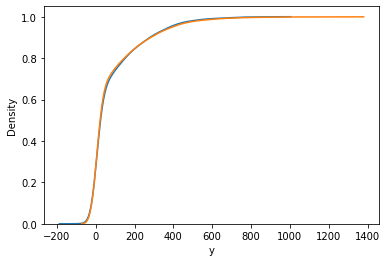

In [ ]:
sns.distplot(modelo_test.predict(Xt_test),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt_test,hist=False,kde_kws={'cumulative':True})

<AxesSubplot:xlabel='y', ylabel='Density'>

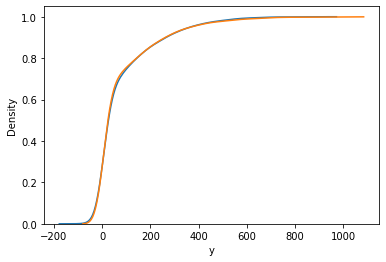

In [ ]:
sns.distplot(modelo_test.predict(Xv_test),hist=False,kde_kws={'cumulative':True})
sns.distplot(yv_test,hist=False,kde_kws={'cumulative':True})

In [ ]:
Xv_test['y^'] = modelo_test.predict(Xv_test)
Xv_test['y'] = yv_test

In [ ]:
modelo_test.coef_

array([-1.48760393e-01, -1.48760393e-01,  1.33688497e-01, -8.21227846e-01,
       -1.80719876e-01,  1.03225620e+00, -1.48760393e-01, -1.48760393e-01,
        3.47944646e-01, -1.04221773e-03, -1.30113183e+00, -4.62142203e-03,
       -1.48760393e-01, -1.48760393e-01,  2.49133424e-02,  7.01695131e-01,
       -7.00091044e-01, -8.87602136e-02, -1.24168639e+00,  1.17520706e+00,
        1.25832842e-02,  2.84669706e-02,  3.69635076e-01, -5.15159571e-01,
        1.14446785e-11, -1.80533366e-12, -7.77923529e-01, -7.69044832e-01,
        2.89467352e+00,  1.30259978e-01, -1.48760393e-01, -1.48760393e-01,
       -1.48760393e-01,  1.07424143e+00,  5.39737947e-01, -3.65926858e-01,
       -5.71023681e-01, -2.96726946e+00,  1.29557904e+00, -1.48760393e-01,
       -1.48760393e-01, -1.48760393e-01, -4.76540925e-01, -1.75090748e-01,
        2.93042754e-01,  1.09945962e+00,  1.09507451e+00, -9.74702102e-01,
       -1.48760393e-01, -1.48760393e-01, -1.48760393e-01, -7.57862669e-01,
       -7.88799788e-01, -

# Juntamos todas las funciones para predecir con todos los chunks

In [ ]:
%%time
number = 1

for chunk in iterator:
    
    print(f'Model number {number}')
    
    chunk = data_filter(chunk)
    chunk = dates(chunk)
    chunk = hours_catalog(chunk)
    
    hri,hrf = chunk[['id_hour']].describe().T[['min','max']].values[0].tolist()
    vobs = 24
    vdes = 1
    anclai = int(hri)+vobs-1
    anclaf = int(hrf)-vdes
    um = ['PULocationID', 'ancla']
    ancla = 24
    step = 4
    varc = ['trip_distance', 'total_amount', 'n']
    vard = ['hora']
    
    print(f'Hra inicial: {hri}, Modelo: {number}')
    print(f'Hra final: {hrf}, Modelo: {number}')
    
    X = pd.concat(map(lambda ancla:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
           map(lambda k:trans(chunk,ancla,k),range(step,vobs+step,step))),range(anclai,anclaf+1)),ignore_index=True)
    y= pd.concat(map(lambda ancla: target(chunk,ancla,vdes),range(anclai,anclaf+1)),ignore_index=True)
    
    tad = TAD(X, y, um)
    varc = [v for v in tad.columns if v[:2]=="v_"]
    tgt = 'y'
    
    miss = 1-tad[varc].describe().T[['count']]/len(tad)
    
    X, Xi = impute(tad, varc)
    
    extreme(X, um, tad)
    
    
    regression(tad, tgt, Xi)
    
    number += 1
    

Model number 1
Hra inicial: 1.0, Modelo: 1
Hra final: 112.0, Modelo: 1
                         variable        ks
3     v_hora_min_total_amount_1_4  0.294406
4     v_hora_min_total_amount_2_4  0.316723
6    v_hora_min_trip_distance_1_4  0.312624
7    v_hora_min_trip_distance_2_4  0.323951
12    v_hora_max_total_amount_1_4  0.312452
..                            ...       ...
444              v_hora_sum_n_0_8  0.266582
445   v_hora_sum_total_amount_0_8  0.266818
446  v_hora_sum_trip_distance_0_8  0.266700
448   v_hora_std_total_amount_0_8  0.288464
449  v_hora_std_trip_distance_0_8  0.288464

[156 rows x 2 columns]
count    9722.000000
mean        0.358465
std         0.479574
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.9s finished


20.273030561524145
21.221870140119716
Model number 2
Hra inicial: 1.0, Modelo: 2
Hra final: 102.0, Modelo: 2
                         variable        ks
2     v_hora_min_total_amount_0_4  0.309644
4    v_hora_min_trip_distance_0_4  0.332447
8     v_hora_max_total_amount_0_4  0.332247
10   v_hora_max_trip_distance_0_4  0.332647
14   v_hora_mean_total_amount_0_4  0.332647
..                            ...       ...
444              v_hora_sum_n_3_4  0.355825
445   v_hora_sum_total_amount_3_4  0.356324
446  v_hora_sum_trip_distance_3_4  0.356324
448   v_hora_std_total_amount_3_4  0.364684
449  v_hora_std_trip_distance_3_4  0.364684

[158 rows x 2 columns]
count    9946.000000
mean        0.343957
std         0.475051
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


18.60260041725355
21.379964186065628
Model number 3
Hra inicial: 1.0, Modelo: 3
Hra final: 88.0, Modelo: 3
                         variable        ks
2     v_hora_min_total_amount_0_4  0.325413
4    v_hora_min_trip_distance_0_4  0.335711
8     v_hora_max_total_amount_0_4  0.340345
10   v_hora_max_trip_distance_0_4  0.340345
14   v_hora_mean_total_amount_0_4  0.340602
..                            ...       ...
444              v_hora_sum_n_3_4  0.374098
445   v_hora_sum_total_amount_3_4  0.374098
446  v_hora_sum_trip_distance_3_4  0.374098
448   v_hora_std_total_amount_3_4  0.382892
449  v_hora_std_trip_distance_3_4  0.382892

[149 rows x 2 columns]
count    8300.000000
mean        0.358313
std         0.479534
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


18.52988202358354
20.64480239621461
Model number 4
Hra inicial: 1.0, Modelo: 4
Hra final: 106.0, Modelo: 4
                         variable        ks
2     v_hora_min_total_amount_3_4  0.317567
4    v_hora_min_trip_distance_3_4  0.338055
8     v_hora_max_total_amount_3_4  0.339722
10   v_hora_max_trip_distance_3_4  0.340437
14   v_hora_mean_total_amount_3_4  0.340914
..                            ...       ...
444              v_hora_sum_n_2_4  0.341912
445   v_hora_sum_total_amount_2_4  0.341912
446  v_hora_sum_trip_distance_2_4  0.341912
448   v_hora_std_total_amount_2_4  0.357772
449  v_hora_std_trip_distance_2_4  0.357772

[186 rows x 2 columns]
count    9005.000000
mean        0.379678
std         0.485334
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


20.588237664371505
22.18419402304236
Model number 5
Hra inicial: 1.0, Modelo: 5
Hra final: 95.0, Modelo: 5
                         variable        ks
2     v_hora_min_total_amount_3_4  0.324898
4    v_hora_min_trip_distance_3_4  0.353184
8     v_hora_max_total_amount_3_4  0.353444
10   v_hora_max_trip_distance_3_4  0.353444
14   v_hora_mean_total_amount_3_4  0.353444
..                            ...       ...
444              v_hora_sum_n_2_4  0.331166
445   v_hora_sum_total_amount_2_4  0.331166
446  v_hora_sum_trip_distance_2_4  0.331166
448   v_hora_std_total_amount_2_4  0.345822
449  v_hora_std_trip_distance_2_4  0.345822

[157 rows x 2 columns]
count    9305.000000
mean        0.458678
std         0.498316
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


19.913819673818498
21.657401365103272
Model number 6
Hra inicial: 1.0, Modelo: 6
Hra final: 115.0, Modelo: 6
                         variable        ks
2     v_hora_min_total_amount_3_4  0.301584
4    v_hora_min_trip_distance_3_4  0.335919
8     v_hora_max_total_amount_3_4  0.336847
10   v_hora_max_trip_distance_3_4  0.336615
14   v_hora_mean_total_amount_3_4  0.336847
..                            ...       ...
444              v_hora_sum_n_2_4  0.365365
445   v_hora_sum_total_amount_2_4  0.365978
446  v_hora_sum_trip_distance_2_4  0.365978
448   v_hora_std_total_amount_2_4  0.380783
449  v_hora_std_trip_distance_2_4  0.380783

[179 rows x 2 columns]
count    8909.000000
mean        0.424515
std         0.494297
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


20.835495589557866
23.187389926432314
Model number 7
Hra inicial: 1.0, Modelo: 7
Hra final: 90.0, Modelo: 7
                         variable        ks
2     v_hora_min_total_amount_3_4  0.319924
4    v_hora_min_trip_distance_3_4  0.359627
8     v_hora_max_total_amount_3_4  0.359914
10   v_hora_max_trip_distance_3_4  0.359051
14   v_hora_mean_total_amount_3_4  0.359914
..                            ...       ...
444              v_hora_sum_n_2_4  0.341762
445   v_hora_sum_total_amount_2_4  0.342493
446  v_hora_sum_trip_distance_2_4  0.342493
448   v_hora_std_total_amount_2_4  0.357654
449  v_hora_std_trip_distance_2_4  0.357654

[156 rows x 2 columns]
count    8943.000000
mean        0.439114
std         0.496307
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


19.960075643257284
20.345828603005362
Model number 8
Hra inicial: 1.0, Modelo: 8
Hra final: 104.0, Modelo: 8
                         variable        ks
2     v_hora_min_total_amount_3_4  0.303839
4    v_hora_min_trip_distance_3_4  0.337886
8     v_hora_max_total_amount_3_4  0.336712
10   v_hora_max_trip_distance_3_4  0.337886
14   v_hora_mean_total_amount_3_4  0.337886
..                            ...       ...
444              v_hora_sum_n_2_4  0.333406
445   v_hora_sum_total_amount_2_4  0.335472
446  v_hora_sum_trip_distance_2_4  0.335472
448   v_hora_std_total_amount_2_4  0.354297
449  v_hora_std_trip_distance_2_4  0.354297

[171 rows x 2 columns]
count    8886.000000
mean        0.402206
std         0.490371
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


23.01013961973764
24.99805514755819
Model number 9
Hra inicial: 1.0, Modelo: 9
Hra final: 96.0, Modelo: 9
                         variable        ks
2     v_hora_min_total_amount_3_4  0.309947
4    v_hora_min_trip_distance_3_4  0.344065
8     v_hora_max_total_amount_3_4  0.345902
10   v_hora_max_trip_distance_3_4  0.345640
14   v_hora_mean_total_amount_3_4  0.345902
..                            ...       ...
444              v_hora_sum_n_2_4  0.361730
445   v_hora_sum_total_amount_2_4  0.362037
446  v_hora_sum_trip_distance_2_4  0.362037
448   v_hora_std_total_amount_2_4  0.374547
449  v_hora_std_trip_distance_2_4  0.374547

[157 rows x 2 columns]
count    8553.000000
mean        0.484391
std         0.499786
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


20.46529604048277
22.126666410678343
Model number 10
Hra inicial: 1.0, Modelo: 10
Hra final: 146.0, Modelo: 10
                         variable        ks
2     v_hora_min_total_amount_3_4  0.338128
4    v_hora_min_trip_distance_3_4  0.362798
8     v_hora_max_total_amount_3_4  0.363088
10   v_hora_max_trip_distance_3_4  0.363088
14   v_hora_mean_total_amount_3_4  0.363378
..                            ...       ...
444              v_hora_sum_n_2_4  0.318672
445   v_hora_sum_total_amount_2_4  0.319251
446  v_hora_sum_trip_distance_2_4  0.319251
448   v_hora_std_total_amount_2_4  0.337625
449  v_hora_std_trip_distance_2_4  0.337625

[215 rows x 2 columns]
count    9164.000000
mean        0.349629
std         0.476879
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.4s finished


22.26376561490825
24.695882221501808
Model number 11
Hra inicial: 1.0, Modelo: 11
Hra final: 89.0, Modelo: 11
                         variable        ks
3     v_hora_min_total_amount_0_4  0.303894
4     v_hora_min_total_amount_3_4  0.326219
6    v_hora_min_trip_distance_0_4  0.319620
7    v_hora_min_trip_distance_3_4  0.363834
12    v_hora_max_total_amount_0_4  0.325402
..                            ...       ...
444              v_hora_sum_n_2_8  0.284849
445   v_hora_sum_total_amount_2_8  0.285170
446  v_hora_sum_trip_distance_2_8  0.285170
448   v_hora_std_total_amount_2_8  0.300048
449  v_hora_std_trip_distance_2_8  0.300048

[149 rows x 2 columns]
count    8267.000000
mean        0.376195
std         0.484459
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


22.413104005865357
23.362993958640935
Model number 12
Hra inicial: 1.0, Modelo: 12
Hra final: 103.0, Modelo: 12
                         variable        ks
2     v_hora_min_total_amount_3_4  0.323232
4    v_hora_min_trip_distance_3_4  0.339428
8     v_hora_max_total_amount_3_4  0.340367
10   v_hora_max_trip_distance_3_4  0.340133
14   v_hora_mean_total_amount_3_4  0.340602
..                            ...       ...
444              v_hora_sum_n_2_4  0.321331
445   v_hora_sum_total_amount_2_4  0.321927
446  v_hora_sum_trip_distance_2_4  0.321927
448   v_hora_std_total_amount_2_4  0.340272
449  v_hora_std_trip_distance_2_4  0.340272

[171 rows x 2 columns]
count    9103.000000
mean        0.386136
std         0.486889
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


20.733270520825485
22.84767547323942
Model number 13
Hra inicial: 1.0, Modelo: 13
Hra final: 92.0, Modelo: 13
                         variable        ks
3     v_hora_min_total_amount_2_4  0.348834
4     v_hora_min_total_amount_3_4  0.328590
6    v_hora_min_trip_distance_2_4  0.352909
7    v_hora_min_trip_distance_3_4  0.334217
12    v_hora_max_total_amount_2_4  0.350736
..                            ...       ...
444              v_hora_sum_n_1_8  0.239171
445   v_hora_sum_total_amount_1_8  0.239584
446  v_hora_sum_trip_distance_1_8  0.239584
448   v_hora_std_total_amount_1_8  0.260022
449  v_hora_std_trip_distance_1_8  0.260022

[159 rows x 2 columns]
count    8901.000000
mean        0.371644
std         0.483271
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


22.14069540348587
24.70556524464409
Model number 14
Hra inicial: 1.0, Modelo: 14
Hra final: 107.0, Modelo: 14
                         variable        ks
2     v_hora_min_total_amount_3_4  0.303339
4    v_hora_min_trip_distance_3_4  0.339151
8     v_hora_max_total_amount_3_4  0.338677
10   v_hora_max_trip_distance_3_4  0.339151
14   v_hora_mean_total_amount_3_4  0.339151
..                            ...       ...
444              v_hora_sum_n_2_4  0.321437
445   v_hora_sum_total_amount_2_4  0.321640
446  v_hora_sum_trip_distance_2_4  0.321640
448   v_hora_std_total_amount_2_4  0.340337
449  v_hora_std_trip_distance_2_4  0.340337

[182 rows x 2 columns]
count    8900.000000
mean        0.412247
std         0.492267
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


22.7531841733594
25.016075834055417
Model number 15
Hra inicial: 1.0, Modelo: 15
Hra final: 133.0, Modelo: 15
                          variable        ks
3      v_hora_min_total_amount_1_4  0.290815
4      v_hora_min_total_amount_3_4  0.343840
6     v_hora_min_trip_distance_1_4  0.289624
7     v_hora_min_trip_distance_3_4  0.364778
12     v_hora_max_total_amount_1_4  0.290935
..                             ...       ...
431  v_hora_sum_trip_distance_0_20  0.103090
433   v_hora_std_total_amount_0_20  0.142414
434  v_hora_std_trip_distance_0_20  0.142312
448   v_hora_std_total_amount_0_24  0.136787
449  v_hora_std_trip_distance_0_24  0.136626

[182 rows x 2 columns]
count    11692.000000
mean         0.360931
std          0.480291
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


23.242340030948615
25.32417575726628
Model number 16
Hra inicial: 1.0, Modelo: 16
Hra final: 116.0, Modelo: 16
                         variable        ks
2     v_hora_min_total_amount_3_4  0.304439
4    v_hora_min_trip_distance_3_4  0.345276
8     v_hora_max_total_amount_3_4  0.345492
10   v_hora_max_trip_distance_3_4  0.345708
14   v_hora_mean_total_amount_3_4  0.345924
..                            ...       ...
444              v_hora_sum_n_2_4  0.312624
445   v_hora_sum_total_amount_2_4  0.313107
446  v_hora_sum_trip_distance_2_4  0.313107
448   v_hora_std_total_amount_2_4  0.332885
449  v_hora_std_trip_distance_2_4  0.332885

[179 rows x 2 columns]
count    10391.000000
mean         0.391974
std          0.488214
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


17.966183684394124
20.83769542396312
Model number 17
Hra inicial: 1.0, Modelo: 17
Hra final: 143.0, Modelo: 17
                         variable        ks
2     v_hora_min_total_amount_3_4  0.317584
4    v_hora_min_trip_distance_3_4  0.322451
8     v_hora_max_total_amount_3_4  0.328187
10   v_hora_max_trip_distance_3_4  0.332533
14   v_hora_mean_total_amount_3_4  0.332707
..                            ...       ...
444              v_hora_sum_n_2_4  0.351205
445   v_hora_sum_total_amount_2_4  0.351412
446  v_hora_sum_trip_distance_2_4  0.351412
448   v_hora_std_total_amount_2_4  0.368639
449  v_hora_std_trip_distance_2_4  0.368639

[177 rows x 2 columns]
count    11441.000000
mean         0.355039
std          0.478546
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


20.03269777097902
21.15850294931547
Model number 18
Hra inicial: 1.0, Modelo: 18
Hra final: 126.0, Modelo: 18
                         variable        ks
2     v_hora_min_total_amount_0_4  0.335072
4    v_hora_min_trip_distance_0_4  0.357956
8     v_hora_max_total_amount_0_4  0.363255
10   v_hora_max_trip_distance_0_4  0.363737
14   v_hora_mean_total_amount_0_4  0.363737
..                            ...       ...
443  v_hora_sum_trip_distance_3_4  0.365988
445   v_hora_std_total_amount_3_4  0.375259
446  v_hora_std_trip_distance_3_4  0.375259
448   v_hora_std_total_amount_3_8  0.318443
449  v_hora_std_trip_distance_3_8  0.318443

[184 rows x 2 columns]
count    11095.000000
mean         0.345741
std          0.475631
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished


24.415737580069084
27.25388088347151
Model number 19
Hra inicial: 1.0, Modelo: 19
Hra final: 142.0, Modelo: 19
                         variable        ks
3     v_hora_min_total_amount_0_4  0.323062
4     v_hora_min_total_amount_3_4  0.341907
6    v_hora_min_trip_distance_0_4  0.331670
7    v_hora_min_trip_distance_3_4  0.366966
12    v_hora_max_total_amount_0_4  0.332514
..                            ...       ...
444              v_hora_sum_n_2_8  0.288801
445   v_hora_sum_total_amount_2_8  0.289034
446  v_hora_sum_trip_distance_2_8  0.289034
448   v_hora_std_total_amount_2_8  0.305433
449  v_hora_std_trip_distance_2_8  0.305433

[212 rows x 2 columns]
count    11780.000000
mean         0.406791
std          0.491256
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


28.24847718451469
31.879031715355953
Model number 20
Hra inicial: 1.0, Modelo: 20
Hra final: 154.0, Modelo: 20
                          variable        ks
4      v_hora_min_total_amount_0_4  0.329864
5      v_hora_min_total_amount_2_4  0.317566
6      v_hora_min_total_amount_3_4  0.341500
8     v_hora_min_trip_distance_0_4  0.349104
9     v_hora_min_trip_distance_2_4  0.315444
..                             ...       ...
443  v_hora_std_trip_distance_0_16  0.211033
445   v_hora_std_total_amount_0_20  0.176663
446  v_hora_std_trip_distance_0_20  0.176663
448   v_hora_std_total_amount_0_24  0.169616
449  v_hora_std_trip_distance_0_24  0.169383

[193 rows x 2 columns]
count    11004.000000
mean         0.465376
std          0.498822
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.6s finished


24.501210175940923
25.269203415534818
Model number 21
Hra inicial: 1.0, Modelo: 21
Hra final: 160.0, Modelo: 21
                          variable        ks
2      v_hora_min_total_amount_0_4  0.359136
4     v_hora_min_trip_distance_0_4  0.363894
8      v_hora_max_total_amount_0_4  0.364646
10    v_hora_max_trip_distance_0_4  0.364896
14    v_hora_mean_total_amount_0_4  0.364896
..                             ...       ...
443   v_hora_std_trip_distance_3_8  0.304593
445   v_hora_std_total_amount_3_12  0.256614
446  v_hora_std_trip_distance_3_12  0.256712
448   v_hora_std_total_amount_3_16  0.208478
449  v_hora_std_trip_distance_3_16  0.208478

[210 rows x 2 columns]
count    10798.000000
mean         0.329598
std          0.470089
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


27.672118946811327
27.103221450617283
Model number 22
Hra inicial: 1.0, Modelo: 22
Hra final: 153.0, Modelo: 22
                          variable        ks
4      v_hora_min_total_amount_0_4  0.304831
5      v_hora_min_total_amount_2_4  0.342226
6      v_hora_min_total_amount_3_4  0.347756
8     v_hora_min_trip_distance_0_4  0.320423
9     v_hora_min_trip_distance_2_4  0.343023
..                             ...       ...
401  v_hora_sum_trip_distance_1_12  0.150275
403   v_hora_std_total_amount_1_12  0.170184
404  v_hora_std_trip_distance_1_12  0.170322
418   v_hora_std_total_amount_1_16  0.108038
419  v_hora_std_trip_distance_1_16  0.108038

[195 rows x 2 columns]
count    11217.000000
mean         0.354819
std          0.478480
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.4s finished


22.854320533711796
23.66896533586926
Model number 23
Hra inicial: 1.0, Modelo: 23
Hra final: 147.0, Modelo: 23
                         variable        ks
2     v_hora_min_total_amount_1_4  0.309869
4    v_hora_min_trip_distance_1_4  0.320104
8     v_hora_max_total_amount_1_4  0.321620
10   v_hora_max_trip_distance_1_4  0.321620
14   v_hora_mean_total_amount_1_4  0.321809
..                            ...       ...
444              v_hora_sum_n_0_4  0.388138
445   v_hora_sum_total_amount_0_4  0.389246
446  v_hora_sum_trip_distance_0_4  0.389246
448   v_hora_std_total_amount_0_4  0.400703
449  v_hora_std_trip_distance_0_4  0.400703

[202 rows x 2 columns]
count    9537.000000
mean        0.431582
std         0.495323
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


24.350337508721296
25.170927575733106
Model number 24
Hra inicial: 1.0, Modelo: 24
Hra final: 144.0, Modelo: 24
                         variable        ks
3     v_hora_min_total_amount_1_4  0.319332
4     v_hora_min_total_amount_2_4  0.308106
6    v_hora_min_trip_distance_1_4  0.317355
7    v_hora_min_trip_distance_2_4  0.325374
12    v_hora_max_total_amount_1_4  0.322298
..                            ...       ...
444              v_hora_sum_n_0_8  0.280020
445   v_hora_sum_total_amount_0_8  0.281421
446  v_hora_sum_trip_distance_0_8  0.281421
448   v_hora_std_total_amount_0_8  0.307461
449  v_hora_std_trip_distance_0_8  0.307606

[180 rows x 2 columns]
count    11031.000000
mean         0.539208
std          0.498483
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.4s finished


25.275820982466254
26.84289346909171
Model number 25
Hra inicial: 1.0, Modelo: 25
Hra final: 160.0, Modelo: 25
                         variable        ks
2     v_hora_min_total_amount_1_4  0.284356
4    v_hora_min_trip_distance_1_4  0.301597
8     v_hora_max_total_amount_1_4  0.302674
10   v_hora_max_trip_distance_1_4  0.303428
14   v_hora_mean_total_amount_1_4  0.303536
..                            ...       ...
444              v_hora_sum_n_0_4  0.365852
445   v_hora_sum_total_amount_0_4  0.366234
446  v_hora_sum_trip_distance_0_4  0.366234
448   v_hora_std_total_amount_0_4  0.381980
449  v_hora_std_trip_distance_0_4  0.381980

[189 rows x 2 columns]
count    14345.000000
mean         0.521575
std          0.499552
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.8s finished


15.62403935088599
15.72821747819033
Model number 26
Hra inicial: 1.0, Modelo: 26
Hra final: 132.0, Modelo: 26
                         variable        ks
3     v_hora_min_total_amount_0_4  0.336986
4     v_hora_min_total_amount_1_4  0.289289
6    v_hora_min_trip_distance_0_4  0.344723
7    v_hora_min_trip_distance_1_4  0.297169
12    v_hora_max_total_amount_0_4  0.358756
..                            ...       ...
444              v_hora_sum_n_3_8  0.295209
445   v_hora_sum_total_amount_3_8  0.295824
446  v_hora_sum_trip_distance_3_8  0.295824
448   v_hora_std_total_amount_3_8  0.310217
449  v_hora_std_trip_distance_3_8  0.310217

[165 rows x 2 columns]
count    14130.000000
mean         0.376008
std          0.484399
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.1s finished


13.192612262963541
13.653208225285992
Model number 27
Hra inicial: 1.0, Modelo: 27
Hra final: 124.0, Modelo: 27
                         variable        ks
3     v_hora_min_total_amount_1_4  0.310565
4     v_hora_min_total_amount_2_4  0.285368
6    v_hora_min_trip_distance_1_4  0.324209
7    v_hora_min_trip_distance_2_4  0.301876
12    v_hora_max_total_amount_1_4  0.335698
..                            ...       ...
444              v_hora_sum_n_0_8  0.298246
445   v_hora_sum_total_amount_0_8  0.298246
446  v_hora_sum_trip_distance_0_8  0.298246
448   v_hora_std_total_amount_0_8  0.320351
449  v_hora_std_trip_distance_0_8  0.320351

[193 rows x 2 columns]
count    11400.000000
mean         0.369035
std          0.482565
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


21.23920962522277
22.501058242526323
Model number 28
Hra inicial: 1.0, Modelo: 28
Hra final: 111.0, Modelo: 28
                         variable        ks
2     v_hora_min_total_amount_3_4  0.277975
4    v_hora_min_trip_distance_3_4  0.311990
8     v_hora_max_total_amount_3_4  0.313507
10   v_hora_max_trip_distance_3_4  0.313074
14   v_hora_mean_total_amount_3_4  0.313507
..                            ...       ...
444              v_hora_sum_n_2_4  0.358160
445   v_hora_sum_total_amount_2_4  0.358487
446  v_hora_sum_trip_distance_2_4  0.358487
448   v_hora_std_total_amount_2_4  0.375884
449  v_hora_std_trip_distance_2_4  0.375884

[171 rows x 2 columns]
count    7759.000000
mean        0.415260
std         0.492799
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


27.533174956929063
29.098483706231203
Model number 29
Hra inicial: 1.0, Modelo: 29
Hra final: 128.0, Modelo: 29
                         variable        ks
2     v_hora_min_total_amount_2_4  0.330801
4    v_hora_min_trip_distance_2_4  0.336392
8     v_hora_max_total_amount_2_4  0.336840
10   v_hora_max_trip_distance_2_4  0.336169
14   v_hora_mean_total_amount_2_4  0.337063
..                            ...       ...
444              v_hora_sum_n_1_4  0.330588
445   v_hora_sum_total_amount_1_4  0.331225
446  v_hora_sum_trip_distance_1_4  0.331225
448   v_hora_std_total_amount_1_4  0.346146
449  v_hora_std_trip_distance_1_4  0.346146

[153 rows x 2 columns]
count    9249.000000
mean        0.341334
std         0.474183
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished


20.925215520893076
22.456492558123752
Model number 30
Hra inicial: 1.0, Modelo: 30
Hra final: 138.0, Modelo: 30
                         variable        ks
2     v_hora_min_total_amount_3_4  0.299400
4    v_hora_min_trip_distance_3_4  0.338416
8     v_hora_max_total_amount_3_4  0.338416
10   v_hora_max_trip_distance_3_4  0.338693
14   v_hora_mean_total_amount_3_4  0.338693
..                            ...       ...
444              v_hora_sum_n_2_4  0.292776
445   v_hora_sum_total_amount_2_4  0.292963
446  v_hora_sum_trip_distance_2_4  0.292963
448   v_hora_std_total_amount_2_4  0.313521
449  v_hora_std_trip_distance_2_4  0.313521

[195 rows x 2 columns]
count    7588.000000
mean        0.404850
std         0.490895
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


24.21530064673154
27.566101992370736
Model number 31
Hra inicial: 1.0, Modelo: 31
Hra final: 137.0, Modelo: 31
                         variable        ks
3     v_hora_min_total_amount_2_4  0.326570
4     v_hora_min_total_amount_3_4  0.309715
6    v_hora_min_trip_distance_2_4  0.349824
7    v_hora_min_trip_distance_3_4  0.332236
12    v_hora_max_total_amount_2_4  0.348004
..                            ...       ...
443  v_hora_std_trip_distance_1_4  0.332501
445   v_hora_std_total_amount_1_8  0.263373
446  v_hora_std_trip_distance_1_8  0.263373
448   v_hora_std_total_amount_2_4  0.364588
449  v_hora_std_trip_distance_2_4  0.364588

[168 rows x 2 columns]
count    11609.000000
mean         0.368076
std          0.482303
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished


23.740832305214393
24.90876095455296
Model number 32
Hra inicial: 1.0, Modelo: 32
Hra final: 105.0, Modelo: 32
                         variable        ks
2     v_hora_min_total_amount_3_4  0.292254
4    v_hora_min_trip_distance_3_4  0.342853
8     v_hora_max_total_amount_3_4  0.342853
10   v_hora_max_trip_distance_3_4  0.343144
14   v_hora_mean_total_amount_3_4  0.343144
..                            ...       ...
444              v_hora_sum_n_2_4  0.285212
445   v_hora_sum_total_amount_2_4  0.285212
446  v_hora_sum_trip_distance_2_4  0.285212
448   v_hora_std_total_amount_2_4  0.304328
449  v_hora_std_trip_distance_2_4  0.304328

[197 rows x 2 columns]
count    7533.000000
mean        0.336254
std         0.472458
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


25.048336808561913
27.512935988332174
Model number 33
Hra inicial: 1.0, Modelo: 33
Hra final: 116.0, Modelo: 33
                         variable        ks
3     v_hora_min_total_amount_0_4  0.276857
4     v_hora_min_total_amount_3_4  0.304458
6    v_hora_min_trip_distance_0_4  0.299020
7    v_hora_min_trip_distance_3_4  0.340906
12    v_hora_max_total_amount_0_4  0.318544
..                            ...       ...
444              v_hora_sum_n_2_8  0.268149
445   v_hora_sum_total_amount_2_8  0.268614
446  v_hora_sum_trip_distance_2_8  0.268614
448   v_hora_std_total_amount_2_8  0.285193
449  v_hora_std_trip_distance_2_8  0.285326

[151 rows x 2 columns]
count    9988.000000
mean        0.388967
std         0.487540
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished


23.881725197137555
26.349440333915744
Model number 34
Hra inicial: 1.0, Modelo: 34
Hra final: 109.0, Modelo: 34
                         variable        ks
2     v_hora_min_total_amount_3_4  0.316842
4    v_hora_min_trip_distance_3_4  0.342911
8     v_hora_max_total_amount_3_4  0.342051
10   v_hora_max_trip_distance_3_4  0.343484
14   v_hora_mean_total_amount_3_4  0.343770
..                            ...       ...
444              v_hora_sum_n_2_4  0.298172
445   v_hora_sum_total_amount_2_4  0.298172
446  v_hora_sum_trip_distance_2_4  0.298172
448   v_hora_std_total_amount_2_4  0.314998
449  v_hora_std_trip_distance_2_4  0.314998

[193 rows x 2 columns]
count    7681.000000
mean        0.489650
std         0.499925
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


22.688675785916455
26.47507515275461
Model number 35
Hra inicial: 1.0, Modelo: 35
Hra final: 122.0, Modelo: 35
                          variable        ks
4      v_hora_min_total_amount_0_4  0.317773
5      v_hora_min_total_amount_1_4  0.312442
6      v_hora_min_total_amount_3_4  0.285832
8     v_hora_min_trip_distance_0_4  0.348165
9     v_hora_min_trip_distance_1_4  0.313665
..                             ...       ...
443   v_hora_std_trip_distance_0_8  0.290185
445   v_hora_std_total_amount_0_12  0.218937
446  v_hora_std_trip_distance_0_12  0.218937
448   v_hora_std_total_amount_0_16  0.148396
449  v_hora_std_trip_distance_0_16  0.148396

[177 rows x 2 columns]
count    9453.000000
mean        0.353539
std         0.478093
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


25.232549579634032
28.730609415067818
Model number 36
Hra inicial: 1.0, Modelo: 36
Hra final: 121.0, Modelo: 36
                         variable        ks
2     v_hora_min_total_amount_0_4  0.343931
4    v_hora_min_trip_distance_0_4  0.344158
8     v_hora_max_total_amount_0_4  0.349386
10   v_hora_max_trip_distance_0_4  0.349386
14   v_hora_mean_total_amount_0_4  0.349614
..                            ...       ...
444              v_hora_sum_n_3_4  0.344627
445   v_hora_sum_total_amount_3_4  0.344627
446  v_hora_sum_trip_distance_3_4  0.344627
448   v_hora_std_total_amount_3_4  0.353525
449  v_hora_std_trip_distance_3_4  0.353525

[148 rows x 2 columns]
count    10227.000000
mean         0.327564
std          0.469348
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


20.42167170786316
22.021682406393587
Model number 37
Hra inicial: 1.0, Modelo: 37
Hra final: 112.0, Modelo: 37
                         variable        ks
2     v_hora_min_total_amount_3_4  0.320970
4    v_hora_min_trip_distance_3_4  0.346435
8     v_hora_max_total_amount_3_4  0.346156
10   v_hora_max_trip_distance_3_4  0.346995
14   v_hora_mean_total_amount_3_4  0.346995
..                            ...       ...
444              v_hora_sum_n_2_4  0.335736
445   v_hora_sum_total_amount_2_4  0.335736
446  v_hora_sum_trip_distance_2_4  0.335736
448   v_hora_std_total_amount_2_4  0.346257
449  v_hora_std_trip_distance_2_4  0.346257

[171 rows x 2 columns]
count    8115.000000
mean        0.295132
std         0.456130
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


27.270103244730908
29.247823098864433
Model number 38
Hra inicial: 1.0, Modelo: 38
Hra final: 94.0, Modelo: 38
                         variable        ks
2     v_hora_min_total_amount_0_4  0.359413
4    v_hora_min_trip_distance_0_4  0.358768
8     v_hora_max_total_amount_0_4  0.359736
10   v_hora_max_trip_distance_0_4  0.359736
14   v_hora_mean_total_amount_0_4  0.359736
..                            ...       ...
444              v_hora_sum_n_3_4  0.337604
445   v_hora_sum_total_amount_3_4  0.337604
446  v_hora_sum_trip_distance_3_4  0.337604
448   v_hora_std_total_amount_3_4  0.346772
449  v_hora_std_trip_distance_3_4  0.346772

[155 rows x 2 columns]
count    7962.000000
mean        0.343507
std         0.474909
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


23.93022838586399
25.115925875013364
Model number 39
Hra inicial: 1.0, Modelo: 39
Hra final: 98.0, Modelo: 39
                         variable        ks
2     v_hora_min_total_amount_3_4  0.352106
4    v_hora_min_trip_distance_3_4  0.361270
8     v_hora_max_total_amount_3_4  0.361975
10   v_hora_max_trip_distance_3_4  0.361975
14   v_hora_mean_total_amount_3_4  0.361975
..                            ...       ...
444              v_hora_sum_n_2_4  0.350228
445   v_hora_sum_total_amount_2_4  0.350542
446  v_hora_sum_trip_distance_2_4  0.350542
448   v_hora_std_total_amount_2_4  0.360587
449  v_hora_std_trip_distance_2_4  0.360587

[189 rows x 2 columns]
count    7467.000000
mean        0.346324
std         0.475830
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.1s finished


28.73051107282419
30.54790957025032
Model number 40
Hra inicial: 1.0, Modelo: 40
Hra final: 88.0, Modelo: 40
                         variable        ks
2     v_hora_min_total_amount_0_4  0.300114
4    v_hora_min_trip_distance_0_4  0.341318
8     v_hora_max_total_amount_0_4  0.340396
10   v_hora_max_trip_distance_0_4  0.341626
14   v_hora_mean_total_amount_0_4  0.341933
..                            ...       ...
444              v_hora_sum_n_3_4  0.368103
445   v_hora_sum_total_amount_3_4  0.368103
446  v_hora_sum_trip_distance_3_4  0.368103
448   v_hora_std_total_amount_3_4  0.374911
449  v_hora_std_trip_distance_3_4  0.374911

[157 rows x 2 columns]
count    7035.000000
mean        0.358493
std         0.479592
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


26.80187720505111
30.028102800558482
Model number 41
Hra inicial: 1.0, Modelo: 41
Hra final: 117.0, Modelo: 41
                         variable        ks
2     v_hora_min_total_amount_3_4  0.315157
4    v_hora_min_trip_distance_3_4  0.314482
8     v_hora_max_total_amount_3_4  0.314932
10   v_hora_max_trip_distance_3_4  0.314707
14   v_hora_mean_total_amount_3_4  0.315157
..                            ...       ...
444              v_hora_sum_n_2_4  0.353728
445   v_hora_sum_total_amount_2_4  0.354370
446  v_hora_sum_trip_distance_2_4  0.354370
448   v_hora_std_total_amount_2_4  0.365530
449  v_hora_std_trip_distance_2_4  0.366253

[186 rows x 2 columns]
count    7574.000000
mean        0.298917
std         0.457814
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


33.03939185765333
34.87615591691577
Model number 42
Hra inicial: 1.0, Modelo: 42
Hra final: 104.0, Modelo: 42
                         variable        ks
3     v_hora_min_total_amount_0_4  0.306735
4     v_hora_min_total_amount_3_4  0.305682
6    v_hora_min_trip_distance_0_4  0.320912
7    v_hora_min_trip_distance_3_4  0.353522
12    v_hora_max_total_amount_0_4  0.318850
..                            ...       ...
444              v_hora_sum_n_2_8  0.284700
445   v_hora_sum_total_amount_2_8  0.284700
446  v_hora_sum_trip_distance_2_8  0.284700
448   v_hora_std_total_amount_2_8  0.299350
449  v_hora_std_trip_distance_2_8  0.299564

[149 rows x 2 columns]
count    6991.000000
mean        0.375769
std         0.484355
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.0s finished


24.90521459749188
27.306942676855865
Model number 43
Hra inicial: 1.0, Modelo: 43
Hra final: 104.0, Modelo: 43
                         variable        ks
2     v_hora_min_total_amount_3_4  0.315079
4    v_hora_min_trip_distance_3_4  0.320006
8     v_hora_max_total_amount_3_4  0.320266
10   v_hora_max_trip_distance_3_4  0.320266
14   v_hora_mean_total_amount_3_4  0.320266
..                            ...       ...
444              v_hora_sum_n_2_4  0.300225
445   v_hora_sum_total_amount_2_4  0.300225
446  v_hora_sum_trip_distance_2_4  0.300225
448   v_hora_std_total_amount_2_4  0.315089
449  v_hora_std_trip_distance_2_4  0.315089

[199 rows x 2 columns]
count    6879.000000
mean        0.370257
std         0.482909
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


29.81055265940465
31.66805168589905
Model number 44
Hra inicial: 1.0, Modelo: 44
Hra final: 113.0, Modelo: 44
                         variable        ks
2     v_hora_min_total_amount_1_4  0.300499
4    v_hora_min_trip_distance_1_4  0.331075
8     v_hora_max_total_amount_1_4  0.331325
10   v_hora_max_trip_distance_1_4  0.331325
14   v_hora_mean_total_amount_1_4  0.331576
..                            ...       ...
444              v_hora_sum_n_0_4  0.349186
445   v_hora_sum_total_amount_0_4  0.350076
446  v_hora_sum_trip_distance_0_4  0.350076
448   v_hora_std_total_amount_0_4  0.360122
449  v_hora_std_trip_distance_0_4  0.360122

[176 rows x 2 columns]
count    7864.000000
mean        0.425356
std         0.494428
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


28.44942440835707
73.210470896344
Model number 45
Hra inicial: 1.0, Modelo: 45
Hra final: 118.0, Modelo: 45
                          variable        ks
4      v_hora_min_total_amount_0_4  0.315925
5      v_hora_min_total_amount_2_4  0.297702
6      v_hora_min_total_amount_3_4  0.342103
8     v_hora_min_trip_distance_0_4  0.339416
9     v_hora_min_trip_distance_2_4  0.332422
..                             ...       ...
443   v_hora_std_trip_distance_3_8  0.325313
445   v_hora_std_total_amount_3_12  0.278615
446  v_hora_std_trip_distance_3_12  0.278203
448   v_hora_std_total_amount_3_16  0.229257
449  v_hora_std_trip_distance_3_16  0.229257

[222 rows x 2 columns]
count    9156.000000
mean        0.373198
std         0.483680
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


31.529143028896918
34.364907008321296
Model number 46
Hra inicial: 1.0, Modelo: 46
Hra final: 131.0, Modelo: 46
                          variable        ks
4      v_hora_min_total_amount_0_4  0.341812
5      v_hora_min_total_amount_2_4  0.291236
6      v_hora_min_total_amount_3_4  0.289065
8     v_hora_min_trip_distance_0_4  0.352564
9     v_hora_min_trip_distance_2_4  0.285680
..                             ...       ...
443  v_hora_std_trip_distance_1_16  0.159898
445   v_hora_std_total_amount_1_20  0.117187
446  v_hora_std_trip_distance_1_20  0.117438
448   v_hora_std_total_amount_1_24  0.108155
449  v_hora_std_trip_distance_1_24  0.107994

[190 rows x 2 columns]
count    8579.000000
mean        0.325562
std         0.468612
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


30.281143870607057
33.10827818079189
Model number 47
Hra inicial: 1.0, Modelo: 47
Hra final: 118.0, Modelo: 47
                          variable        ks
3      v_hora_min_total_amount_2_4  0.321292
4      v_hora_min_total_amount_3_4  0.314154
6     v_hora_min_trip_distance_2_4  0.310019
7     v_hora_min_trip_distance_3_4  0.325406
12     v_hora_max_total_amount_2_4  0.324761
..                             ...       ...
443  v_hora_std_trip_distance_1_12  0.220290
445   v_hora_std_total_amount_1_16  0.167041
446  v_hora_std_trip_distance_1_16  0.167158
448   v_hora_std_total_amount_1_20  0.125609
449  v_hora_std_trip_distance_1_20  0.125881

[172 rows x 2 columns]
count    8655.000000
mean        0.404391
std         0.490802
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


35.76041321708803
37.93890549414058
Model number 48
Hra inicial: 1.0, Modelo: 48
Hra final: 137.0, Modelo: 48
                          variable        ks
4      v_hora_min_total_amount_0_4  0.344768
5      v_hora_min_total_amount_1_4  0.307321
6      v_hora_min_total_amount_2_4  0.308509
8     v_hora_min_trip_distance_0_4  0.351303
9     v_hora_min_trip_distance_1_4  0.331806
..                             ...       ...
443  v_hora_std_trip_distance_0_12  0.230660
445    v_hora_std_total_amount_1_4  0.354725
446   v_hora_std_trip_distance_1_4  0.354725
448    v_hora_std_total_amount_1_8  0.282368
449   v_hora_std_trip_distance_1_8  0.282368

[213 rows x 2 columns]
count    9222.000000
mean        0.298308
std         0.457540
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


27.965038481073034
29.021418052020145
Model number 49
Hra inicial: 1.0, Modelo: 49
Hra final: 115.0, Modelo: 49
                          variable        ks
3      v_hora_min_total_amount_2_4  0.318883
4      v_hora_min_total_amount_3_4  0.309753
6     v_hora_min_trip_distance_2_4  0.336194
7     v_hora_min_trip_distance_3_4  0.327961
12     v_hora_max_total_amount_2_4  0.336194
..                             ...       ...
440   v_hora_std_trip_distance_1_8  0.273366
442   v_hora_std_total_amount_1_12  0.203870
443  v_hora_std_trip_distance_1_12  0.203797
445   v_hora_std_total_amount_1_16  0.133702
446  v_hora_std_trip_distance_1_16  0.133702

[180 rows x 2 columns]
count    9394.000000
mean        0.302853
std         0.459517
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


28.49369264414102
31.069288257336353
Model number 50
Hra inicial: 1.0, Modelo: 50
Hra final: 107.0, Modelo: 50
                         variable        ks
2     v_hora_min_total_amount_2_4  0.276330
4    v_hora_min_trip_distance_2_4  0.294548
8     v_hora_max_total_amount_2_4  0.281200
10   v_hora_max_trip_distance_2_4  0.294909
14   v_hora_mean_total_amount_2_4  0.294909
..                            ...       ...
444              v_hora_sum_n_1_4  0.333603
445   v_hora_sum_total_amount_1_4  0.333855
446  v_hora_sum_trip_distance_1_4  0.333855
448   v_hora_std_total_amount_1_4  0.350840
449  v_hora_std_trip_distance_1_4  0.350840

[185 rows x 2 columns]
count    7978.000000
mean        0.322387
std         0.467419
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


22.21045369648579
24.238982866053874
Model number 51
Hra inicial: 1.0, Modelo: 51
Hra final: 92.0, Modelo: 51
                         variable        ks
3     v_hora_min_total_amount_0_4  0.317034
4     v_hora_min_total_amount_1_4  0.288030
6    v_hora_min_trip_distance_0_4  0.352105
7    v_hora_min_trip_distance_1_4  0.321428
12    v_hora_max_total_amount_0_4  0.364730
..                            ...       ...
444              v_hora_sum_n_3_8  0.266554
445   v_hora_sum_total_amount_3_8  0.266406
446  v_hora_sum_trip_distance_3_8  0.266406
448   v_hora_std_total_amount_3_8  0.279650
449  v_hora_std_trip_distance_3_8  0.279485

[156 rows x 2 columns]
count    7702.000000
mean        0.341600
std         0.474277
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


27.46069516129394
28.821586649653618
Model number 52
Hra inicial: 1.0, Modelo: 52
Hra final: 103.0, Modelo: 52
                         variable        ks
2     v_hora_min_total_amount_3_4  0.320407
4    v_hora_min_trip_distance_3_4  0.372816
8     v_hora_max_total_amount_3_4  0.373213
10   v_hora_max_trip_distance_3_4  0.374007
14   v_hora_mean_total_amount_3_4  0.374801
..                            ...       ...
444              v_hora_sum_n_2_4  0.338184
445   v_hora_sum_total_amount_2_4  0.338462
446  v_hora_sum_trip_distance_2_4  0.338462
448   v_hora_std_total_amount_2_4  0.351724
449  v_hora_std_trip_distance_2_4  0.351724

[197 rows x 2 columns]
count    7540.000000
mean        0.328515
std         0.469704
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


28.28703287893133
32.68700698036451
Model number 53
Hra inicial: 1.0, Modelo: 53
Hra final: 90.0, Modelo: 53
                         variable        ks
3     v_hora_min_total_amount_0_4  0.288761
4     v_hora_min_total_amount_3_4  0.329389
6    v_hora_min_trip_distance_0_4  0.314612
7    v_hora_min_trip_distance_3_4  0.353525
12    v_hora_max_total_amount_0_4  0.329606
..                            ...       ...
444              v_hora_sum_n_2_8  0.265947
445   v_hora_sum_total_amount_2_8  0.266094
446  v_hora_sum_trip_distance_2_8  0.266094
448   v_hora_std_total_amount_2_8  0.282348
449  v_hora_std_trip_distance_2_8  0.282348

[150 rows x 2 columns]
count    7747.000000
mean        0.415516
std         0.492843
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


27.650259746099973
30.609192630400685
Model number 54
Hra inicial: 1.0, Modelo: 54
Hra final: 96.0, Modelo: 54
                         variable        ks
2     v_hora_min_total_amount_3_4  0.316491
4    v_hora_min_trip_distance_3_4  0.308535
8     v_hora_max_total_amount_3_4  0.316491
10   v_hora_max_trip_distance_3_4  0.316491
14   v_hora_mean_total_amount_3_4  0.316491
..                            ...       ...
444              v_hora_sum_n_2_4  0.326311
445   v_hora_sum_total_amount_2_4  0.326582
446  v_hora_sum_trip_distance_2_4  0.326582
448   v_hora_std_total_amount_2_4  0.343881
449  v_hora_std_trip_distance_2_4  0.343881

[202 rows x 2 columns]
count    6937.000000
mean        0.404209
std         0.490774
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


28.52087229323462
29.79114458033737
Model number 55
Hra inicial: 1.0, Modelo: 55
Hra final: 100.0, Modelo: 55
                         variable        ks
3     v_hora_min_total_amount_0_4  0.310947
4     v_hora_min_total_amount_1_4  0.278077
6    v_hora_min_trip_distance_0_4  0.328324
7    v_hora_min_trip_distance_1_4  0.317548
12    v_hora_max_total_amount_0_4  0.334726
..                            ...       ...
444              v_hora_sum_n_3_8  0.262237
445   v_hora_sum_total_amount_3_8  0.262362
446  v_hora_sum_trip_distance_3_8  0.262362
448   v_hora_std_total_amount_3_8  0.275896
449  v_hora_std_trip_distance_3_8  0.275896

[148 rows x 2 columns]
count    8858.000000
mean        0.358885
std         0.479700
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


24.126607309037645
26.978223356795247
Model number 56
Hra inicial: 1.0, Modelo: 56
Hra final: 130.0, Modelo: 56
                          variable        ks
2      v_hora_min_total_amount_0_4  0.353988
4     v_hora_min_trip_distance_0_4  0.353236
8      v_hora_max_total_amount_0_4  0.353988
10    v_hora_max_trip_distance_0_4  0.353988
14    v_hora_mean_total_amount_0_4  0.353988
..                             ...       ...
443  v_hora_std_trip_distance_0_24  0.137353
445    v_hora_std_total_amount_3_4  0.384405
446   v_hora_std_trip_distance_3_4  0.384405
448    v_hora_std_total_amount_3_8  0.340954
449   v_hora_std_trip_distance_3_8  0.340954

[204 rows x 2 columns]
count    9689.000000
mean        0.315822
std         0.464866
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished


28.697347639157368
30.04414989885776
Model number 57
Hra inicial: 1.0, Modelo: 57
Hra final: 135.0, Modelo: 57
                          variable        ks
3      v_hora_min_total_amount_0_4  0.338636
4      v_hora_min_total_amount_3_4  0.298212
6     v_hora_min_trip_distance_0_4  0.340568
7     v_hora_min_trip_distance_3_4  0.323661
12     v_hora_max_total_amount_0_4  0.341534
..                             ...       ...
443  v_hora_std_trip_distance_0_16  0.170943
445   v_hora_std_total_amount_0_20  0.130542
446  v_hora_std_trip_distance_0_20  0.130463
448   v_hora_std_total_amount_0_24  0.124884
449  v_hora_std_trip_distance_0_24  0.124660

[175 rows x 2 columns]
count    8943.000000
mean        0.328525
std         0.469703
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


31.989595537675694
34.139793088746075
Model number 58
Hra inicial: 1.0, Modelo: 58
Hra final: 124.0, Modelo: 58
                          variable        ks
3      v_hora_min_total_amount_1_4  0.330752
4      v_hora_min_total_amount_2_4  0.301836
6     v_hora_min_trip_distance_1_4  0.329961
7     v_hora_min_trip_distance_2_4  0.307691
12     v_hora_max_total_amount_1_4  0.330752
..                             ...       ...
431  v_hora_std_trip_distance_0_20  0.117849
445   v_hora_std_total_amount_0_24  0.112377
446  v_hora_std_trip_distance_0_24  0.112407
448    v_hora_std_total_amount_2_4  0.324172
449   v_hora_std_trip_distance_2_4  0.324172

[228 rows x 2 columns]
count    9879.000000
mean        0.330600
std         0.470453
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


28.280222000132387
30.461160370292042
Model number 59
Hra inicial: 1.0, Modelo: 59
Hra final: 168.0, Modelo: 59
                          variable        ks
3      v_hora_min_total_amount_1_4  0.283640
4      v_hora_min_total_amount_2_4  0.336128
6     v_hora_min_trip_distance_1_4  0.311893
7     v_hora_min_trip_distance_2_4  0.349968
12     v_hora_max_total_amount_1_4  0.311893
..                             ...       ...
443   v_hora_std_trip_distance_0_8  0.266340
445   v_hora_std_total_amount_0_12  0.199358
446  v_hora_std_trip_distance_0_12  0.199233
448   v_hora_std_total_amount_0_16  0.142134
449  v_hora_std_trip_distance_0_16  0.142134

[178 rows x 2 columns]
count    10640.000000
mean         0.323872
std          0.467974
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


30.127080234389013
31.78072937576433
Model number 60
Hra inicial: 1.0, Modelo: 60
Hra final: 180.0, Modelo: 60
                         variable        ks
3     v_hora_min_total_amount_0_4  0.301745
4     v_hora_min_total_amount_3_4  0.332852
6    v_hora_min_trip_distance_0_4  0.340286
7    v_hora_min_trip_distance_3_4  0.349021
12    v_hora_max_total_amount_0_4  0.354678
..                            ...       ...
444              v_hora_sum_n_2_4  0.303921
445   v_hora_sum_total_amount_2_4  0.304076
446  v_hora_sum_trip_distance_2_4  0.304076
448   v_hora_std_total_amount_2_4  0.321930
449  v_hora_std_trip_distance_2_4  0.321930

[228 rows x 2 columns]
count    10041.000000
mean         0.389901
std          0.487752
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished


27.560880086743467
33.05718938851384
Model number 61
Hra inicial: 1.0, Modelo: 61
Hra final: 133.0, Modelo: 61
                          variable        ks
2      v_hora_min_total_amount_1_4  0.326735
4     v_hora_min_trip_distance_1_4  0.328333
8      v_hora_max_total_amount_1_4  0.329931
10    v_hora_max_trip_distance_1_4  0.329931
14    v_hora_mean_total_amount_1_4  0.330131
..                             ...       ...
440  v_hora_std_trip_distance_0_16  0.160391
442   v_hora_std_total_amount_0_20  0.108057
443  v_hora_std_trip_distance_0_20  0.107943
448    v_hora_std_total_amount_2_4  0.349690
449   v_hora_std_trip_distance_2_4  0.349690

[173 rows x 2 columns]
count    9731.000000
mean        0.386805
std         0.487043
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished


28.003582250794953
28.431991067049797
Model number 62
Hra inicial: 1.0, Modelo: 62
Hra final: 84.0, Modelo: 62
                         variable        ks
3     v_hora_min_total_amount_1_4  0.325051
4     v_hora_min_total_amount_2_4  0.286719
6    v_hora_min_trip_distance_1_4  0.327755
7    v_hora_min_trip_distance_2_4  0.297799
12    v_hora_max_total_amount_1_4  0.335868
..                            ...       ...
444              v_hora_sum_n_0_8  0.299789
445   v_hora_sum_total_amount_0_8  0.301185
446  v_hora_sum_trip_distance_0_8  0.301185
448   v_hora_std_total_amount_0_8  0.316458
449  v_hora_std_trip_distance_0_8  0.316458

[156 rows x 2 columns]
count    7595.000000
mean        0.326399
std         0.468926
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


30.016780161837232
30.5809297496137
Model number 63
Hra inicial: 1.0, Modelo: 63
Hra final: 98.0, Modelo: 63
                         variable        ks
3     v_hora_min_total_amount_0_4  0.330968
4     v_hora_min_total_amount_3_4  0.334881
6    v_hora_min_trip_distance_0_4  0.357316
7    v_hora_min_trip_distance_3_4  0.333329
12    v_hora_max_total_amount_0_4  0.368866
..                            ...       ...
443  v_hora_sum_trip_distance_2_4  0.302853
445   v_hora_std_total_amount_2_4  0.317371
446  v_hora_std_trip_distance_2_4  0.317371
448   v_hora_std_total_amount_3_4  0.345644
449  v_hora_std_trip_distance_3_4  0.345644

[190 rows x 2 columns]
count    7852.000000
mean        0.510698
std         0.499917
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


25.08045942201939
27.464505082542033
Model number 64
Hra inicial: 1.0, Modelo: 64
Hra final: 93.0, Modelo: 64
                         variable        ks
3     v_hora_min_total_amount_0_4  0.366313
4     v_hora_min_total_amount_1_4  0.268738
6    v_hora_min_trip_distance_0_4  0.358895
7    v_hora_min_trip_distance_1_4  0.310749
12    v_hora_max_total_amount_0_4  0.366313
..                            ...       ...
444              v_hora_sum_n_3_4  0.338407
445   v_hora_sum_total_amount_3_4  0.338407
446  v_hora_sum_trip_distance_3_4  0.338407
448   v_hora_std_total_amount_3_4  0.347656
449  v_hora_std_trip_distance_3_4  0.347656

[154 rows x 2 columns]
count    7785.000000
mean        0.329994
std         0.470241
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


22.949901515718686
26.322088782474225
Model number 65
Hra inicial: 1.0, Modelo: 65
Hra final: 94.0, Modelo: 65
                         variable        ks
3     v_hora_min_total_amount_0_4  0.302765
4     v_hora_min_total_amount_3_4  0.345351
6    v_hora_min_trip_distance_0_4  0.336870
7    v_hora_min_trip_distance_3_4  0.351581
12    v_hora_max_total_amount_0_4  0.341286
..                            ...       ...
444              v_hora_sum_n_2_4  0.322209
445   v_hora_sum_total_amount_2_4  0.322622
446  v_hora_sum_trip_distance_2_4  0.322622
448   v_hora_std_total_amount_2_4  0.336790
449  v_hora_std_trip_distance_2_4  0.336790

[164 rows x 2 columns]
count    8814.000000
mean        0.429204
std         0.494991
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


24.36153466637995
25.603913205088897
Model number 66
Hra inicial: 1.0, Modelo: 66
Hra final: 149.0, Modelo: 66
                          variable        ks
3      v_hora_min_total_amount_0_4  0.337303
4      v_hora_min_total_amount_1_4  0.301495
6     v_hora_min_trip_distance_0_4  0.346321
7     v_hora_min_trip_distance_1_4  0.295871
12     v_hora_max_total_amount_0_4  0.346808
..                             ...       ...
443  v_hora_std_trip_distance_0_16  0.206522
445   v_hora_std_total_amount_0_20  0.165627
446  v_hora_std_trip_distance_0_20  0.165680
448   v_hora_std_total_amount_0_24  0.158607
449  v_hora_std_trip_distance_0_24  0.158557

[199 rows x 2 columns]
count    9289.000000
mean        0.370438
std         0.482948
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


27.876274015709274
29.91844052730849
Model number 67
Hra inicial: 1.0, Modelo: 67
Hra final: 114.0, Modelo: 67
                         variable        ks
3     v_hora_min_total_amount_2_4  0.324651
4     v_hora_min_total_amount_3_4  0.309102
6    v_hora_min_trip_distance_2_4  0.316906
7    v_hora_min_trip_distance_3_4  0.315594
12    v_hora_max_total_amount_2_4  0.325906
..                            ...       ...
443  v_hora_std_trip_distance_0_4  0.344692
445   v_hora_std_total_amount_3_4  0.340083
446  v_hora_std_trip_distance_3_4  0.340083
448   v_hora_std_total_amount_3_8  0.265876
449  v_hora_std_trip_distance_3_8  0.265876

[181 rows x 2 columns]
count    9102.000000
mean        0.416612
std         0.493024
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


30.068388845386426
31.84669059110893
Model number 68
Hra inicial: 1.0, Modelo: 68
Hra final: 163.0, Modelo: 68
                          variable        ks
3      v_hora_min_total_amount_1_4  0.309967
4      v_hora_min_total_amount_2_4  0.319478
6     v_hora_min_trip_distance_1_4  0.304418
7     v_hora_min_trip_distance_2_4  0.321728
12     v_hora_max_total_amount_1_4  0.320907
..                             ...       ...
440  v_hora_std_trip_distance_0_12  0.247460
442   v_hora_std_total_amount_0_16  0.178802
443  v_hora_std_trip_distance_0_16  0.178654
445   v_hora_std_total_amount_0_20  0.115357
446  v_hora_std_trip_distance_0_20  0.115357

[203 rows x 2 columns]
count    11317.000000
mean         0.329593
std          0.470086
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


24.930241994195427
26.835512773031272
Model number 69
Hra inicial: 1.0, Modelo: 69
Hra final: 158.0, Modelo: 69
                         variable        ks
2     v_hora_min_total_amount_1_4  0.310837
4    v_hora_min_trip_distance_1_4  0.311731
8     v_hora_max_total_amount_1_4  0.314414
10   v_hora_max_trip_distance_1_4  0.315130
14   v_hora_mean_total_amount_1_4  0.315130
..                            ...       ...
444              v_hora_sum_n_0_4  0.336985
445   v_hora_sum_total_amount_0_4  0.337421
446  v_hora_sum_trip_distance_0_4  0.337421
448   v_hora_std_total_amount_0_4  0.352796
449  v_hora_std_trip_distance_0_4  0.352796

[184 rows x 2 columns]
count    9531.000000
mean        0.315287
std         0.464654
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


27.01629953255536
29.813146508487236
Model number 70
Hra inicial: 1.0, Modelo: 70
Hra final: 170.0, Modelo: 70
                          variable        ks
3      v_hora_min_total_amount_1_4  0.295882
4      v_hora_min_total_amount_2_4  0.301320
6     v_hora_min_trip_distance_1_4  0.306127
7     v_hora_min_trip_distance_2_4  0.303453
12     v_hora_max_total_amount_1_4  0.307214
..                             ...       ...
443  v_hora_std_trip_distance_0_16  0.197611
445   v_hora_std_total_amount_0_20  0.162675
446  v_hora_std_trip_distance_0_20  0.162394
448   v_hora_std_total_amount_0_24  0.154809
449  v_hora_std_trip_distance_0_24  0.154853

[215 rows x 2 columns]
count    10272.000000
mean         0.367991
std          0.482282
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.1s finished


26.22866865594998
30.272595114272086
Model number 71
Hra inicial: 1.0, Modelo: 71
Hra final: 93.0, Modelo: 71
                         variable        ks
2     v_hora_min_total_amount_0_4  0.335441
4    v_hora_min_trip_distance_0_4  0.359933
8     v_hora_max_total_amount_0_4  0.363963
10   v_hora_max_trip_distance_0_4  0.363343
14   v_hora_mean_total_amount_0_4  0.363963
..                            ...       ...
444              v_hora_sum_n_3_4  0.339564
445   v_hora_sum_total_amount_3_4  0.339564
446  v_hora_sum_trip_distance_3_4  0.339564
448   v_hora_std_total_amount_3_4  0.351564
449  v_hora_std_trip_distance_3_4  0.351564

[164 rows x 2 columns]
count    8630.000000
mean        0.356315
std         0.478938
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


21.625311570754683
24.028939111542044
Model number 72
Hra inicial: 1.0, Modelo: 72
Hra final: 124.0, Modelo: 72
                         variable        ks
2     v_hora_min_total_amount_2_4  0.311252
4    v_hora_min_trip_distance_2_4  0.320063
8     v_hora_max_total_amount_2_4  0.314133
10   v_hora_max_trip_distance_2_4  0.323621
14   v_hora_mean_total_amount_2_4  0.323621
..                            ...       ...
444              v_hora_sum_n_1_4  0.305253
445   v_hora_sum_total_amount_1_4  0.306127
446  v_hora_sum_trip_distance_1_4  0.306127
448   v_hora_std_total_amount_1_4  0.323990
449  v_hora_std_trip_distance_1_4  0.323990

[184 rows x 2 columns]
count    10837.000000
mean         0.331642
std          0.470825
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.5s finished


25.28633107723789
26.812830994677473
Model number 73
Hra inicial: 1.0, Modelo: 73
Hra final: 93.0, Modelo: 73
                         variable        ks
2     v_hora_min_total_amount_0_4  0.308404
4    v_hora_min_trip_distance_0_4  0.329732
8     v_hora_max_total_amount_0_4  0.342640
10   v_hora_max_trip_distance_0_4  0.343202
14   v_hora_mean_total_amount_0_4  0.343202
..                            ...       ...
444              v_hora_sum_n_3_4  0.369409
445   v_hora_sum_total_amount_3_4  0.369409
446  v_hora_sum_trip_distance_3_4  0.369409
448   v_hora_std_total_amount_3_4  0.378354
449  v_hora_std_trip_distance_3_4  0.378354

[156 rows x 2 columns]
count    7810.000000
mean        0.368246
std         0.482359
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


24.960744403563517
27.032219627847788
Model number 74
Hra inicial: 1.0, Modelo: 74
Hra final: 102.0, Modelo: 74
                         variable        ks
2     v_hora_min_total_amount_3_4  0.300310
4    v_hora_min_trip_distance_3_4  0.311651
8     v_hora_max_total_amount_3_4  0.312523
10   v_hora_max_trip_distance_3_4  0.312087
14   v_hora_mean_total_amount_3_4  0.312742
..                            ...       ...
444              v_hora_sum_n_2_4  0.350089
445   v_hora_sum_total_amount_2_4  0.351011
446  v_hora_sum_trip_distance_2_4  0.351011
448   v_hora_std_total_amount_2_4  0.368363
449  v_hora_std_trip_distance_2_4  0.368363

[192 rows x 2 columns]
count    7665.000000
mean        0.336334
std         0.472486
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


30.571015843429638
31.513369565217392
Model number 75
Hra inicial: 1.0, Modelo: 75
Hra final: 79.0, Modelo: 75
                         variable        ks
2     v_hora_min_total_amount_3_4  0.279917
4    v_hora_min_trip_distance_3_4  0.314972
8     v_hora_max_total_amount_3_4  0.318926
10   v_hora_max_trip_distance_3_4  0.319717
14   v_hora_mean_total_amount_3_4  0.319717
..                            ...       ...
444              v_hora_sum_n_2_4  0.342253
445   v_hora_sum_total_amount_2_4  0.342253
446  v_hora_sum_trip_distance_2_4  0.342253
448   v_hora_std_total_amount_2_4  0.355740
449  v_hora_std_trip_distance_2_4  0.355740

[151 rows x 2 columns]
count    6736.000000
mean        0.455760
std         0.498076
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


18.451639418488213
20.941196427010176
Model number 76
Hra inicial: 1.0, Modelo: 76
Hra final: 102.0, Modelo: 76
                         variable        ks
2     v_hora_min_total_amount_3_4  0.349693
4    v_hora_min_trip_distance_3_4  0.361020
8     v_hora_max_total_amount_3_4  0.362435
10   v_hora_max_trip_distance_3_4  0.362081
14   v_hora_mean_total_amount_3_4  0.362435
..                            ...       ...
444              v_hora_sum_n_2_4  0.351713
445   v_hora_sum_total_amount_2_4  0.352353
446  v_hora_sum_trip_distance_2_4  0.352353
448   v_hora_std_total_amount_2_4  0.363484
449  v_hora_std_trip_distance_2_4  0.363484

[187 rows x 2 columns]
count    7457.000000
mean        0.338474
std         0.473222
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


22.71803484593975
24.209088692498725
Model number 77
Hra inicial: 1.0, Modelo: 77
Hra final: 86.0, Modelo: 77
                         variable        ks
3     v_hora_min_total_amount_0_4  0.290134
4     v_hora_min_total_amount_3_4  0.305894
6    v_hora_min_trip_distance_0_4  0.314652
7    v_hora_min_trip_distance_3_4  0.342202
12    v_hora_max_total_amount_0_4  0.316014
..                            ...       ...
444              v_hora_sum_n_2_4  0.361435
445   v_hora_sum_total_amount_2_4  0.361780
446  v_hora_sum_trip_distance_2_4  0.361780
448   v_hora_std_total_amount_2_4  0.374539
449  v_hora_std_trip_distance_2_4  0.374539

[164 rows x 2 columns]
count    7588.000000
mean        0.362546
std         0.480767
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


21.94742117757541
25.32316615439948
Model number 78
Hra inicial: 1.0, Modelo: 78
Hra final: 91.0, Modelo: 78
                          variable        ks
3      v_hora_min_total_amount_0_4  0.340569
4      v_hora_min_total_amount_3_4  0.332367
6     v_hora_min_trip_distance_0_4  0.371198
7     v_hora_min_trip_distance_3_4  0.329595
12     v_hora_max_total_amount_0_4  0.370833
..                             ...       ...
443   v_hora_std_trip_distance_0_8  0.322997
445   v_hora_std_total_amount_0_12  0.263722
446  v_hora_std_trip_distance_0_12  0.263581
448   v_hora_std_total_amount_0_16  0.206523
449  v_hora_std_trip_distance_0_16  0.206080

[204 rows x 2 columns]
count    7949.000000
mean        0.335640
std         0.472243
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


22.88937039671069
24.959081768572517
Model number 79
Hra inicial: 1.0, Modelo: 79
Hra final: 95.0, Modelo: 79
                         variable        ks
3     v_hora_min_total_amount_0_4  0.365597
4     v_hora_min_total_amount_1_4  0.289551
6    v_hora_min_trip_distance_0_4  0.368493
7    v_hora_min_trip_distance_1_4  0.279805
12    v_hora_max_total_amount_0_4  0.367769
..                            ...       ...
444              v_hora_sum_n_3_8  0.305093
445   v_hora_sum_total_amount_3_8  0.305497
446  v_hora_sum_trip_distance_3_8  0.305497
448   v_hora_std_total_amount_3_8  0.316602
449  v_hora_std_trip_distance_3_8  0.316602

[164 rows x 2 columns]
count    7770.000000
mean        0.392793
std         0.488403
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


23.89731184449266
26.101203073141633
Model number 80
Hra inicial: 1.0, Modelo: 80
Hra final: 90.0, Modelo: 80
                         variable        ks
2     v_hora_min_total_amount_0_4  0.321401
4    v_hora_min_trip_distance_0_4  0.344148
8     v_hora_max_total_amount_0_4  0.356850
10   v_hora_max_trip_distance_0_4  0.358918
14   v_hora_mean_total_amount_0_4  0.358622
..                            ...       ...
444              v_hora_sum_n_3_4  0.346629
445   v_hora_sum_total_amount_3_4  0.347422
446  v_hora_sum_trip_distance_3_4  0.347422
448   v_hora_std_total_amount_3_4  0.357408
449  v_hora_std_trip_distance_3_4  0.357408

[163 rows x 2 columns]
count    8612.000000
mean        0.328147
std         0.469566
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


21.981170152652442
26.0913178900632
Model number 81
Hra inicial: 1.0, Modelo: 81
Hra final: 151.0, Modelo: 81
                          variable        ks
2      v_hora_min_total_amount_3_4  0.338551
4     v_hora_min_trip_distance_3_4  0.363575
8      v_hora_max_total_amount_3_4  0.364648
10    v_hora_max_trip_distance_3_4  0.365005
14    v_hora_mean_total_amount_3_4  0.365005
..                             ...       ...
443   v_hora_std_trip_distance_0_8  0.276265
445   v_hora_std_total_amount_0_12  0.219546
446  v_hora_std_trip_distance_0_12  0.219236
448   v_hora_std_total_amount_0_16  0.162135
449  v_hora_std_trip_distance_0_16  0.162135

[195 rows x 2 columns]
count    7577.000000
mean        0.413356
std         0.492468
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


25.786558238699662
28.815111055419163
Model number 82
Hra inicial: 1.0, Modelo: 82
Hra final: 83.0, Modelo: 82
                         variable        ks
2     v_hora_min_total_amount_3_4  0.322248
4    v_hora_min_trip_distance_3_4  0.332196
8     v_hora_max_total_amount_3_4  0.332457
10   v_hora_max_trip_distance_3_4  0.332457
14   v_hora_mean_total_amount_3_4  0.332719
..                            ...       ...
444              v_hora_sum_n_2_4  0.350224
445   v_hora_sum_total_amount_2_4  0.350224
446  v_hora_sum_trip_distance_2_4  0.350224
448   v_hora_std_total_amount_2_4  0.361937
449  v_hora_std_trip_distance_2_4  0.361937

[148 rows x 2 columns]
count    7598.000000
mean        0.371940
std         0.483354
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


20.342776957342306
21.913808535201195
Model number 83
Hra inicial: 1.0, Modelo: 83
Hra final: 119.0, Modelo: 83
                         variable        ks
2     v_hora_min_total_amount_3_4  0.330621
4    v_hora_min_trip_distance_3_4  0.366031
8     v_hora_max_total_amount_3_4  0.367522
10   v_hora_max_trip_distance_3_4  0.367522
14   v_hora_mean_total_amount_3_4  0.367522
..                            ...       ...
444              v_hora_sum_n_2_4  0.310164
445   v_hora_sum_total_amount_2_4  0.310605
446  v_hora_sum_trip_distance_2_4  0.310605
448   v_hora_std_total_amount_2_4  0.326740
449  v_hora_std_trip_distance_2_4  0.326740

[207 rows x 2 columns]
count    7457.000000
mean        0.313531
std         0.463959
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


25.038008688247032
27.614251648593974
Model number 84
Hra inicial: 1.0, Modelo: 84
Hra final: 109.0, Modelo: 84
                         variable        ks
2     v_hora_min_total_amount_2_4  0.319193
4    v_hora_min_trip_distance_2_4  0.321336
8     v_hora_max_total_amount_2_4  0.323090
10   v_hora_max_trip_distance_2_4  0.323090
14   v_hora_mean_total_amount_2_4  0.323090
..                            ...       ...
444              v_hora_sum_n_1_4  0.319323
445   v_hora_sum_total_amount_1_4  0.320274
446  v_hora_sum_trip_distance_1_4  0.320274
448   v_hora_std_total_amount_1_4  0.338929
449  v_hora_std_trip_distance_1_4  0.338929

[182 rows x 2 columns]
count    9372.000000
mean        0.390738
std         0.487942
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


32.312499174469174
36.02111844894689
Model number 85
Hra inicial: 1.0, Modelo: 85
Hra final: 111.0, Modelo: 85
                         variable        ks
2     v_hora_min_total_amount_3_4  0.281884
4    v_hora_min_trip_distance_3_4  0.299826
8     v_hora_max_total_amount_3_4  0.300224
10   v_hora_max_trip_distance_3_4  0.300025
14   v_hora_mean_total_amount_3_4  0.300424
..                            ...       ...
444              v_hora_sum_n_2_4  0.333730
445   v_hora_sum_total_amount_2_4  0.333730
446  v_hora_sum_trip_distance_2_4  0.333730
448   v_hora_std_total_amount_2_4  0.350616
449  v_hora_std_trip_distance_2_4  0.350616

[188 rows x 2 columns]
count    7551.000000
mean        0.318236
std         0.465822
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


28.93587742641272
31.802386277877222
Model number 86
Hra inicial: 1.0, Modelo: 86
Hra final: 81.0, Modelo: 86
                         variable        ks
2     v_hora_min_total_amount_3_4  0.282707
4    v_hora_min_trip_distance_3_4  0.317361
8     v_hora_max_total_amount_3_4  0.317882
10   v_hora_max_trip_distance_3_4  0.318404
14   v_hora_mean_total_amount_3_4  0.318664
..                            ...       ...
444              v_hora_sum_n_2_4  0.340604
445   v_hora_sum_total_amount_2_4  0.341886
446  v_hora_sum_trip_distance_2_4  0.341886
448   v_hora_std_total_amount_2_4  0.357079
449  v_hora_std_trip_distance_2_4  0.357079

[149 rows x 2 columns]
count    6752.000000
mean        0.507257
std         0.499984
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.8s finished


18.88233658654832
21.30329995917475
Model number 87
Hra inicial: 1.0, Modelo: 87
Hra final: 97.0, Modelo: 87
                         variable        ks
2     v_hora_min_total_amount_3_4  0.366529
4    v_hora_min_trip_distance_3_4  0.372792
8     v_hora_max_total_amount_3_4  0.373160
10   v_hora_max_trip_distance_3_4  0.373160
14   v_hora_mean_total_amount_3_4  0.373160
..                            ...       ...
444              v_hora_sum_n_2_4  0.340790
445   v_hora_sum_total_amount_2_4  0.340790
446  v_hora_sum_trip_distance_2_4  0.340790
448   v_hora_std_total_amount_2_4  0.352162
449  v_hora_std_trip_distance_2_4  0.352162

[188 rows x 2 columns]
count    8002.000000
mean        0.346913
std         0.476018
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


48.854668809141224
47.50895460224906
Model number 88
Hra inicial: 1.0, Modelo: 88
Hra final: 93.0, Modelo: 88
                         variable        ks
2     v_hora_min_total_amount_0_4  0.358465
4    v_hora_min_trip_distance_0_4  0.349379
8     v_hora_max_total_amount_0_4  0.360810
10   v_hora_max_trip_distance_0_4  0.360516
14   v_hora_mean_total_amount_0_4  0.360810
..                            ...       ...
444              v_hora_sum_n_3_4  0.352285
445   v_hora_sum_total_amount_3_4  0.352555
446  v_hora_sum_trip_distance_3_4  0.352555
448   v_hora_std_total_amount_3_4  0.361827
449  v_hora_std_trip_distance_3_4  0.361827

[162 rows x 2 columns]
count    8844.000000
mean        0.375057
std         0.484165
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


18.850480719659245
19.511949089606187
Model number 89
Hra inicial: 1.0, Modelo: 89
Hra final: 120.0, Modelo: 89
                         variable        ks
2     v_hora_min_total_amount_3_4  0.310514
4    v_hora_min_trip_distance_3_4  0.331618
8     v_hora_max_total_amount_3_4  0.339044
10   v_hora_max_trip_distance_3_4  0.339044
14   v_hora_mean_total_amount_3_4  0.339044
..                            ...       ...
444              v_hora_sum_n_2_4  0.353276
445   v_hora_sum_total_amount_2_4  0.353276
446  v_hora_sum_trip_distance_2_4  0.353276
448   v_hora_std_total_amount_2_4  0.365882
449  v_hora_std_trip_distance_2_4  0.365882

[169 rows x 2 columns]
count    10789.000000
mean         0.326444
std          0.468933
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished


21.217825615876684
21.83185281164825
Model number 90
Hra inicial: 1.0, Modelo: 90
Hra final: 114.0, Modelo: 90
                         variable        ks
3     v_hora_min_total_amount_0_4  0.290584
4     v_hora_min_total_amount_3_4  0.375496
6    v_hora_min_trip_distance_0_4  0.301723
7    v_hora_min_trip_distance_3_4  0.387891
12    v_hora_max_total_amount_0_4  0.302853
..                            ...       ...
444              v_hora_sum_n_2_4  0.357459
445   v_hora_sum_total_amount_2_4  0.357982
446  v_hora_sum_trip_distance_2_4  0.357982
448   v_hora_std_total_amount_2_4  0.371736
449  v_hora_std_trip_distance_2_4  0.371736

[201 rows x 2 columns]
count    9652.000000
mean        0.342209
std         0.474474
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


24.312680233843572
26.45449289756352
Model number 91
Hra inicial: 1.0, Modelo: 91
Hra final: 125.0, Modelo: 91
                         variable        ks
3     v_hora_min_total_amount_0_4  0.336802
4     v_hora_min_total_amount_1_4  0.315509
6    v_hora_min_trip_distance_0_4  0.340131
7    v_hora_min_trip_distance_1_4  0.316369
12    v_hora_max_total_amount_0_4  0.337853
..                            ...       ...
444              v_hora_sum_n_3_4  0.338120
445   v_hora_sum_total_amount_3_4  0.338120
446  v_hora_sum_trip_distance_3_4  0.338120
448   v_hora_std_total_amount_3_4  0.349313
449  v_hora_std_trip_distance_3_4  0.349313

[148 rows x 2 columns]
count    12151.000000
mean         0.347626
std          0.476236
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.9s finished


16.469533712391637
17.11087078637635
Model number 92
Hra inicial: 1.0, Modelo: 92
Hra final: 127.0, Modelo: 92
                         variable        ks
2     v_hora_min_total_amount_3_4  0.329709
4    v_hora_min_trip_distance_3_4  0.351494
8     v_hora_max_total_amount_3_4  0.351005
10   v_hora_max_trip_distance_3_4  0.351249
14   v_hora_mean_total_amount_3_4  0.351494
..                            ...       ...
444              v_hora_sum_n_2_4  0.330608
445   v_hora_sum_total_amount_2_4  0.331216
446  v_hora_sum_trip_distance_2_4  0.331216
448   v_hora_std_total_amount_2_4  0.346503
449  v_hora_std_trip_distance_2_4  0.346503

[193 rows x 2 columns]
count    9681.000000
mean        0.507386
std         0.499971
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


21.310448828314946
21.886010370894677
Model number 93
Hra inicial: 1.0, Modelo: 93
Hra final: 107.0, Modelo: 93
                         variable        ks
2     v_hora_min_total_amount_0_4  0.344400
4    v_hora_min_trip_distance_0_4  0.351196
8     v_hora_max_total_amount_0_4  0.351468
10   v_hora_max_trip_distance_0_4  0.351468
14   v_hora_mean_total_amount_0_4  0.352555
..                            ...       ...
444              v_hora_sum_n_3_4  0.348019
445   v_hora_sum_total_amount_3_4  0.348019
446  v_hora_sum_trip_distance_3_4  0.348019
448   v_hora_std_total_amount_3_4  0.357884
449  v_hora_std_trip_distance_3_4  0.357884

[156 rows x 2 columns]
count    8808.000000
mean        0.352066
std         0.477642
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


20.321260792249454
20.890925455373246
Model number 94
Hra inicial: 1.0, Modelo: 94
Hra final: 131.0, Modelo: 94
                         variable        ks
2     v_hora_min_total_amount_3_4  0.360831
4    v_hora_min_trip_distance_3_4  0.356716
8     v_hora_max_total_amount_3_4  0.364945
10   v_hora_max_trip_distance_3_4  0.364945
14   v_hora_mean_total_amount_3_4  0.364945
..                            ...       ...
444              v_hora_sum_n_2_4  0.324665
445   v_hora_sum_total_amount_2_4  0.324883
446  v_hora_sum_trip_distance_2_4  0.324883
448   v_hora_std_total_amount_2_4  0.340603
449  v_hora_std_trip_distance_2_4  0.340603

[199 rows x 2 columns]
count    8551.000000
mean        0.391884
std         0.488200
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


26.82647156998229
38.073480674464165
Model number 95
Hra inicial: 1.0, Modelo: 95
Hra final: 111.0, Modelo: 95
                         variable        ks
2     v_hora_min_total_amount_0_4  0.315287
4    v_hora_min_trip_distance_0_4  0.335170
8     v_hora_max_total_amount_0_4  0.333655
10   v_hora_max_trip_distance_0_4  0.335360
14   v_hora_mean_total_amount_0_4  0.335360
..                            ...       ...
444              v_hora_sum_n_3_4  0.360266
445   v_hora_sum_total_amount_3_4  0.360506
446  v_hora_sum_trip_distance_3_4  0.360506
448   v_hora_std_total_amount_3_4  0.369875
449  v_hora_std_trip_distance_3_4  0.369875

[149 rows x 2 columns]
count    10766.000000
mean         0.433587
std          0.495593
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished


19.405463481873838
20.99583470118393
Model number 96
Hra inicial: 1.0, Modelo: 96
Hra final: 108.0, Modelo: 96
                         variable        ks
2     v_hora_min_total_amount_3_4  0.287430
4    v_hora_min_trip_distance_3_4  0.331759
8     v_hora_max_total_amount_3_4  0.332466
10   v_hora_max_trip_distance_3_4  0.332466
14   v_hora_mean_total_amount_3_4  0.332702
..                            ...       ...
444              v_hora_sum_n_2_4  0.347963
445   v_hora_sum_total_amount_2_4  0.347963
446  v_hora_sum_trip_distance_2_4  0.347963
448   v_hora_std_total_amount_2_4  0.362845
449  v_hora_std_trip_distance_2_4  0.362845

[178 rows x 2 columns]
count    8443.000000
mean        0.533223
std         0.498925
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


21.384235055167668
22.49812805523923
Model number 97
Hra inicial: 1.0, Modelo: 97
Hra final: 121.0, Modelo: 97
                         variable        ks
3     v_hora_min_total_amount_1_4  0.331564
4     v_hora_min_total_amount_2_4  0.303741
6    v_hora_min_trip_distance_1_4  0.336228
7    v_hora_min_trip_distance_2_4  0.308602
12    v_hora_max_total_amount_1_4  0.342800
..                            ...       ...
444              v_hora_sum_n_0_8  0.286207
445   v_hora_sum_total_amount_0_8  0.287252
446  v_hora_sum_trip_distance_0_8  0.287252
448   v_hora_std_total_amount_0_8  0.304268
449  v_hora_std_trip_distance_0_8  0.304268

[169 rows x 2 columns]
count    10337.000000
mean         0.393248
std          0.488495
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


18.760497475353134
20.257989886746582
Model number 98
Hra inicial: 1.0, Modelo: 98
Hra final: 113.0, Modelo: 98
                         variable        ks
3     v_hora_min_total_amount_0_4  0.324032
4     v_hora_min_total_amount_3_4  0.330953
6    v_hora_min_trip_distance_0_4  0.330794
7    v_hora_min_trip_distance_3_4  0.368163
12    v_hora_max_total_amount_0_4  0.345941
..                            ...       ...
444              v_hora_sum_n_2_8  0.272428
445   v_hora_sum_total_amount_2_8  0.272573
446  v_hora_sum_trip_distance_2_8  0.272573
448   v_hora_std_total_amount_2_8  0.287280
449  v_hora_std_trip_distance_2_8  0.287118

[158 rows x 2 columns]
count    8302.000000
mean        0.426644
std         0.494619
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.6s finished


21.232428803729213
22.734390053663518
Model number 99
Hra inicial: 1.0, Modelo: 99
Hra final: 128.0, Modelo: 99
                         variable        ks
2     v_hora_min_total_amount_3_4  0.287004
4    v_hora_min_trip_distance_3_4  0.326557
8     v_hora_max_total_amount_3_4  0.328544
10   v_hora_max_trip_distance_3_4  0.328743
14   v_hora_mean_total_amount_3_4  0.328743
..                            ...       ...
444              v_hora_sum_n_2_4  0.331799
445   v_hora_sum_total_amount_2_4  0.331799
446  v_hora_sum_trip_distance_2_4  0.331799
448   v_hora_std_total_amount_2_4  0.346966
449  v_hora_std_trip_distance_2_4  0.346966

[180 rows x 2 columns]
count    9658.000000
mean        0.380617
std         0.485564
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


24.1537585227281
25.414363984039927
Model number 100
Hra inicial: 1.0, Modelo: 100
Hra final: 102.0, Modelo: 100
                         variable        ks
2     v_hora_min_total_amount_1_4  0.311318
4    v_hora_min_trip_distance_1_4  0.314255
8     v_hora_max_total_amount_1_4  0.313338
10   v_hora_max_trip_distance_1_4  0.314623
14   v_hora_mean_total_amount_1_4  0.314623
..                            ...       ...
444              v_hora_sum_n_0_4  0.343483
445   v_hora_sum_total_amount_0_4  0.345663
446  v_hora_sum_trip_distance_0_4  0.345663
448   v_hora_std_total_amount_0_4  0.362015
449  v_hora_std_trip_distance_0_4  0.362015

[158 rows x 2 columns]
count    9246.000000
mean        0.440623
std         0.496489
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


17.21403195729782
23.727719314383314
Model number 101
Hra inicial: 1.0, Modelo: 101
Hra final: 122.0, Modelo: 101
                         variable        ks
2     v_hora_min_total_amount_3_4  0.316259
4    v_hora_min_trip_distance_3_4  0.346637
8     v_hora_max_total_amount_3_4  0.348991
10   v_hora_max_trip_distance_3_4  0.349462
14   v_hora_mean_total_amount_3_4  0.349462
..                            ...       ...
444              v_hora_sum_n_2_4  0.315712
445   v_hora_sum_total_amount_2_4  0.315886
446  v_hora_sum_trip_distance_2_4  0.315886
448   v_hora_std_total_amount_2_4  0.333232
449  v_hora_std_trip_distance_2_4  0.333232

[185 rows x 2 columns]
count    9858.000000
mean        0.404139
std         0.490749
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


20.47750518608421
21.877227578091023
Model number 102
Hra inicial: 1.0, Modelo: 102
Hra final: 106.0, Modelo: 102
                         variable        ks
3     v_hora_min_total_amount_0_4  0.321594
4     v_hora_min_total_amount_3_4  0.311256
6    v_hora_min_trip_distance_0_4  0.321070
7    v_hora_min_trip_distance_3_4  0.345985
12    v_hora_max_total_amount_0_4  0.321244
..                            ...       ...
444              v_hora_sum_n_2_8  0.269583
445   v_hora_sum_total_amount_2_8  0.269810
446  v_hora_sum_trip_distance_2_8  0.269810
448   v_hora_std_total_amount_2_8  0.288128
449  v_hora_std_trip_distance_2_8  0.288128

[155 rows x 2 columns]
count    10327.000000
mean         0.358478
std          0.479577
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


15.967237906102248
17.715138187711297
Model number 103
Hra inicial: 1.0, Modelo: 103
Hra final: 151.0, Modelo: 103
                         variable        ks
2     v_hora_min_total_amount_3_4  0.323487
4    v_hora_min_trip_distance_3_4  0.358995
8     v_hora_max_total_amount_3_4  0.358750
10   v_hora_max_trip_distance_3_4  0.359240
14   v_hora_mean_total_amount_3_4  0.358261
..                            ...       ...
444              v_hora_sum_n_2_4  0.316402
445   v_hora_sum_total_amount_2_4  0.316734
446  v_hora_sum_trip_distance_2_4  0.316734
448   v_hora_std_total_amount_2_4  0.333621
449  v_hora_std_trip_distance_2_4  0.333621

[193 rows x 2 columns]
count    10422.000000
mean         0.349645
std          0.476881
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


19.656434498380534
22.918693332331213
Model number 104
Hra inicial: 1.0, Modelo: 104
Hra final: 127.0, Modelo: 104
                         variable        ks
2     v_hora_min_total_amount_0_4  0.339284
4    v_hora_min_trip_distance_0_4  0.340227
8     v_hora_max_total_amount_0_4  0.340039
10   v_hora_max_trip_distance_0_4  0.340793
14   v_hora_mean_total_amount_0_4  0.340793
..                            ...       ...
444              v_hora_sum_n_3_4  0.363982
445   v_hora_sum_total_amount_3_4  0.364934
446  v_hora_sum_trip_distance_3_4  0.364934
448   v_hora_std_total_amount_3_4  0.373570
449  v_hora_std_trip_distance_3_4  0.373570

[158 rows x 2 columns]
count    11350.000000
mean         0.390925
std          0.487979
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


16.155188120691825
18.27212395406404
Model number 105
Hra inicial: 1.0, Modelo: 105
Hra final: 112.0, Modelo: 105
                         variable        ks
2     v_hora_min_total_amount_3_4  0.292203
4    v_hora_min_trip_distance_3_4  0.344837
8     v_hora_max_total_amount_3_4  0.345545
10   v_hora_max_trip_distance_3_4  0.344837
14   v_hora_mean_total_amount_3_4  0.345545
..                            ...       ...
444              v_hora_sum_n_2_4  0.332386
445   v_hora_sum_total_amount_2_4  0.333017
446  v_hora_sum_trip_distance_2_4  0.333017
448   v_hora_std_total_amount_2_4  0.351196
449  v_hora_std_trip_distance_2_4  0.351196

[178 rows x 2 columns]
count    9489.000000
mean        0.361787
std         0.480543
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished


19.390384859327256
20.600529088486553
Model number 106
Hra inicial: 1.0, Modelo: 106
Hra final: 132.0, Modelo: 106
                         variable        ks
2     v_hora_min_total_amount_0_4  0.331672
4    v_hora_min_trip_distance_0_4  0.326636
8     v_hora_max_total_amount_0_4  0.335672
10   v_hora_max_trip_distance_0_4  0.335672
14   v_hora_mean_total_amount_0_4  0.335820
..                            ...       ...
444              v_hora_sum_n_3_4  0.363349
445   v_hora_sum_total_amount_3_4  0.363931
446  v_hora_sum_trip_distance_3_4  0.363931
448   v_hora_std_total_amount_3_4  0.374203
449  v_hora_std_trip_distance_3_4  0.374203

[164 rows x 2 columns]
count    13808.000000
mean         0.509632
std          0.499925
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.6s finished


17.461934608856815
17.59139698908438
Model number 107
Hra inicial: 1.0, Modelo: 107
Hra final: 100.0, Modelo: 107
                         variable        ks
3     v_hora_min_total_amount_0_4  0.309532
4     v_hora_min_total_amount_3_4  0.334349
6    v_hora_min_trip_distance_0_4  0.336078
7    v_hora_min_trip_distance_3_4  0.363887
12    v_hora_max_total_amount_0_4  0.340836
..                            ...       ...
444              v_hora_sum_n_2_8  0.261494
445   v_hora_sum_total_amount_2_8  0.261617
446  v_hora_sum_trip_distance_2_8  0.261494
448   v_hora_std_total_amount_2_8  0.278075
449  v_hora_std_trip_distance_2_8  0.278075

[155 rows x 2 columns]
count    8927.000000
mean        0.400022
std         0.489930
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


21.53611314615435
22.005626198994097
Model number 108
Hra inicial: 1.0, Modelo: 108
Hra final: 106.0, Modelo: 108
                         variable        ks
2     v_hora_min_total_amount_3_4  0.316903
4    v_hora_min_trip_distance_3_4  0.332834
8     v_hora_max_total_amount_3_4  0.343128
10   v_hora_max_trip_distance_3_4  0.343373
14   v_hora_mean_total_amount_3_4  0.343373
..                            ...       ...
444              v_hora_sum_n_2_4  0.344352
445   v_hora_sum_total_amount_2_4  0.344600
446  v_hora_sum_trip_distance_2_4  0.344600
448   v_hora_std_total_amount_2_4  0.361217
449  v_hora_std_trip_distance_2_4  0.361217

[181 rows x 2 columns]
count    8955.000000
mean        0.347404
std         0.476172
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


24.39837516299431
27.724445350258698
Model number 109
Hra inicial: 1.0, Modelo: 109
Hra final: 108.0, Modelo: 109
                         variable        ks
3     v_hora_min_total_amount_0_4  0.334047
4     v_hora_min_total_amount_3_4  0.315015
6    v_hora_min_trip_distance_0_4  0.342301
7    v_hora_min_trip_distance_3_4  0.341312
12    v_hora_max_total_amount_0_4  0.351587
..                            ...       ...
444              v_hora_sum_n_2_8  0.251571
445   v_hora_sum_total_amount_2_8  0.251681
446  v_hora_sum_trip_distance_2_8  0.251681
448   v_hora_std_total_amount_2_8  0.267403
449  v_hora_std_trip_distance_2_8  0.267403

[166 rows x 2 columns]
count    9218.000000
mean        0.412020
std         0.492225
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


19.503165438746812
20.780631979257784
Model number 110
Hra inicial: 1.0, Modelo: 110
Hra final: 116.0, Modelo: 110
                         variable        ks
2     v_hora_min_total_amount_3_4  0.326583
4    v_hora_min_trip_distance_3_4  0.353259
8     v_hora_max_total_amount_3_4  0.356348
10   v_hora_max_trip_distance_3_4  0.356068
14   v_hora_mean_total_amount_3_4  0.356348
..                            ...       ...
444              v_hora_sum_n_2_4  0.338631
445   v_hora_sum_total_amount_2_4  0.339589
446  v_hora_sum_trip_distance_2_4  0.339589
448   v_hora_std_total_amount_2_4  0.352928
449  v_hora_std_trip_distance_2_4  0.352928

[188 rows x 2 columns]
count    8846.000000
mean        0.336875
std         0.472669
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


24.975259087763046
26.442598159498317
Model number 111
Hra inicial: 1.0, Modelo: 111
Hra final: 102.0, Modelo: 111
                         variable        ks
2     v_hora_min_total_amount_0_4  0.345952
4    v_hora_min_trip_distance_0_4  0.344243
8     v_hora_max_total_amount_0_4  0.345952
10   v_hora_max_trip_distance_0_4  0.345952
14   v_hora_mean_total_amount_0_4  0.345952
..                            ...       ...
444              v_hora_sum_n_3_4  0.341100
445   v_hora_sum_total_amount_3_4  0.341568
446  v_hora_sum_trip_distance_3_4  0.341568
448   v_hora_std_total_amount_3_4  0.351450
449  v_hora_std_trip_distance_3_4  0.351450

[164 rows x 2 columns]
count    9209.000000
mean        0.404061
std         0.490736
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: extremo, dtype: float64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


18.75571170775452
20.830105257517218
Model number 112
Hra inicial: 1.0, Modelo: 112
Hra final: 30.0, Modelo: 112
                           variable        ks
3       v_hora_min_total_amount_2_4  0.195548
6      v_hora_min_trip_distance_2_4  0.225138
12      v_hora_max_total_amount_2_4  0.225138
15     v_hora_max_trip_distance_2_4  0.225138
21     v_hora_mean_total_amount_2_4  0.225138
24    v_hora_mean_trip_distance_2_4  0.225138
27                 v_hora_sum_n_2_4  0.225138
30      v_hora_sum_total_amount_2_4  0.225138
33     v_hora_sum_trip_distance_2_4  0.225138
39      v_hora_std_total_amount_2_4  0.249995
42     v_hora_std_trip_distance_2_4  0.249995
49      v_hora_min_total_amount_1_8  0.385702
53     v_hora_min_trip_distance_1_8  0.409316
61      v_hora_max_total_amount_1_8  0.417187
65     v_hora_max_trip_distance_1_8  0.417187
73     v_hora_mean_total_amount_1_8  0.417187
77    v_hora_mean_trip_distance_1_8  0.417187
81                 v_hora_sum_n_1_8  0.417187
85      v_hor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished


15.399852347320953
38.200627576156414
CPU times: user 7h 51min 52s, sys: 5min 39s, total: 7h 57min 32s
Wall time: 7h 52min 21s


## Persistencia de los Modelos

In [ ]:
import pickle

In [ ]:
with open("models_other.pkl", "wb") as f:
    for model in models:
         pickle.dump(model, f)

## Si queremos abrir los modelos de nuevo para evitar entrenamiento

In [ ]:
new_models = []
with open("models.pckl", "rb") as f:
    while True:
        try:
            new_models.append(pickle.load(f))
        except EOFError:
            break

In [ ]:
len(new_models)

112